# Polarization analysis

In [151]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc

import pertpy
import pert2state_model

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

To download processed data:
```bash
DROPBOX_PATH=GRNPerturbSeq/3_expts/Diff035scRNAseq/
DATADIR=/mnt/oak/users/emma/data/GWT/

rclone copy dropbox:${DROPBOX_PATH}Diff035_pseudobulk.h5ad ${DATADIR} --checksum --ignore-times
rclone copy dropbox:${DROPBOX_PATH}Diff035_merged.gex.filtered.h5ad ${DATADIR} --checksum --ignore-times
```

In [6]:
combined_signature = pd.read_csv('results/combined_Th2_vs_Th1_signature.csv')

In [7]:
combined_signature

gene_name  padj_hollbacher  zscore_hollbacher       padj_ota  zscore_ota  \
0        TBX21     2.558741e-27         -11.590989  1.371920e-290  -36.630762   
1         GZMK     2.735849e-17          -9.338291   0.000000e+00  -40.699941   
2         LYAR     1.032448e-12          -8.098987   0.000000e+00  -58.090505   
3         GNLY     2.320809e-11          -7.691574   2.762516e-83  -19.578501   
4        EOMES     2.306847e-10          -7.374390   0.000000e+00  -40.299724   
...        ...              ...                ...            ...         ...   
9201     NR4A1              NaN           0.164537   5.907467e-01    0.811208   
9202      RHOB              NaN          -0.196940   7.177238e-03   -3.096717   
9203      RORC              NaN          -0.585678   7.178763e-17   -8.668179   
9204     SMAD1              NaN          -0.503042   3.910949e-01    1.200298   
9205     TTC16              NaN          -0.033609   6.918112e-14   -7.825519   

       padj_Diff043  zscore_Diff043  
0     2.390809e-118      -23.439750  
1      4.680324e-08       -5.934091  
2      3.051003e-37      -13.136328  
3      2.475290e-38      -13.326088  
4      6.839965e-04        3.884069  
...             ...             ...  
9201   3.459588e-03       -3.414320  
9202   3.877044e-20       -9.610396  
9203   9.588959e-06       -4.911131  
9204   5.706436e-02        2.364001  
9205   1.244112e-06       -5.324579  

[9206 rows x 7 columns]

## Load perturb-seq signatures

In [8]:
datadir = '../../../../3_expts/processed_data/CD4i_final/'
experiment_name = 'CD4i_final'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 100)] = 100
for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond

adata_de.var_names = adata_de.var['gene_name'].values
adata_de.var_names

Index(['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC',
       'NFYA', 'STPG1',
       ...
       'ARHGAP11B', 'LINC02929', 'CDR1', 'PRRC2B', 'F8A1', 'HOMEZ', 'C2orf83',
       'ENSG00000290797', 'ENSG00000291096', 'SOD2'],
      dtype='object', length=13959)

In [11]:
# Load summary stats
DE_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
DE_stats = DE_stats[DE_stats['condition'] == 'Rest']
keep_targets = DE_stats[ (DE_stats.n_total_de_genes > 1)].target_name.tolist()
print(len(keep_targets))

6896


## Fit model of target state from perturbations

In [12]:
from pert2state_model.Perturb2StateModel import Perturb2StateModel

In [193]:
#signature = pd.read_csv('results/Ota_Th2vsTh1_DE_results.csv', index_col='variable')
signature = pd.read_csv('results/Diff043Rest_Th2vsTh1_DE_results.csv', index_col='variable')

In [194]:
signature

baseMean    log_fc     lfcSE       stat        p_value  \
variable                                                              
NRP2      2113.413327  6.209682  0.180913  34.324109  3.428881e-258   
SLAMF7    1664.189655 -3.768245  0.143452 -26.268256  4.422444e-152   
HOMER2    1588.187559  4.329263  0.166022  26.076446  6.746132e-150   
NPDC1     3619.711624 -2.818695  0.108930 -25.876087  1.237966e-147   
IL12RB2   2087.262161 -5.751223  0.226676 -25.372012  5.137663e-142   
...               ...       ...       ...        ...            ...   
EPHB6      686.237293  0.000388  0.187965   0.002062   9.983549e-01   
CTBP2      162.395749  0.000473  0.256099   0.001847   9.985264e-01   
NEPRO     6831.373131  0.000096  0.069513   0.001378   9.989003e-01   
IL24       291.292522  0.000318  0.409953   0.000776   9.993811e-01   
SS18L2    8689.705451 -0.000057  0.080065  -0.000709   9.994345e-01   

            adj_p_value             contrast     zscore  
variable                                                 
NRP2      3.899666e-254      Th2_vs_Th1_Rest  34.324109  
SLAMF7    2.514823e-148      Th2_vs_Th1_Rest -26.268256  
HOMER2    2.557459e-146      Th2_vs_Th1_Rest  26.076446  
NPDC1     3.519847e-144      Th2_vs_Th1_Rest -25.876087  
IL12RB2   1.168613e-138      Th2_vs_Th1_Rest -25.372012  
...                 ...                  ...        ...  
EPHB6      9.987060e-01  Th2_vs_Th1_Stim48hr   0.002062  
CTBP2      9.987898e-01  Th2_vs_Th1_Stim48hr   0.001847  
NEPRO      9.990760e-01  Th2_vs_Th1_Stim48hr   0.001378  
IL24       9.994345e-01  Th2_vs_Th1_Stim48hr   0.000776  
SS18L2     9.994345e-01  Th2_vs_Th1_Stim48hr  -0.000709  

[34128 rows x 8 columns]

In [197]:
marker_gene = ['TBX21', 'GATA3', 'IFNG', 'IL4', 'IL5', 'IL13']

In [198]:
perturb_layer = 'zscore'
ctrl_de = None
n_pcs = 60
n_splits = 5
n_repeats = 1
target_state = 'Th2'
cond = 'Rest'

# Get target state values
#y_target = signature['zscore'].copy()
y_target = signature[signature.contrast=='Th2_vs_Th1_Rest']['zscore'].fillna(0).copy()
y_target[marker_gene]=0

# Find common genes between all DE results
common_gs = np.intersect1d(y_target.index, adata_de.var_names)
print(f"Common genes between target and adata_de: {len(common_gs)}")

if ctrl_de is not None:
    # Map gene IDs to gene names for K562 comparison
    common_gs_ids_df = adata_de[:, common_gs].var[['gene_ids', 'gene_name']]
    common_gs_ids = common_gs_ids_df[common_gs_ids_df.gene_name.isin(ctrl_de.var_names)].gene_name
    print(f"Common gene IDs with K562: {len(common_gs_ids)}")
    
    k562_de_test = ctrl_de[:, ctrl_de.var_names.isin(common_gs_ids)].copy()
    common_gs = np.intersect1d(common_gs, k562_de_test.var_names)

y_target = y_target.loc[common_gs]

# Get responses in stim cells
print(f"Getting perturbation responses for condition: {cond}")
X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
                            ['target_contrast_gene_name'] + list(common_gs), 
                            layer=perturb_layer)
X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
print(f"Perturbation matrix shape: {X_perturbs.shape}")

Common genes between target and adata_de: 10929
Getting perturbation responses for condition: Rest
Perturbation matrix shape: (10929, 11288)


In [199]:
# Mask effects in cis
X_perturbs_masked = X_perturbs.copy()
mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
for idx in X_perturbs_masked.index:
    if idx in X_perturbs_masked.columns:
        mask.loc[idx, idx] = True
X_perturbs_masked = X_perturbs_masked.mask(mask)
# Impute masked values with column means
X_perturbs_masked = X_perturbs_masked.fillna(X_perturbs_masked.mean())

# Train model on CD4 cells
print(f"Training CD4 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
p2t_model = Perturb2StateModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{cond}')
print(f"CD4 model training complete.")

print(f"Model training for {target_state} completed successfully")

Training CD4 model with 60 PCs, 5 splits, 1 repeats
CD4 model training complete.
Model training for Th2 completed successfully


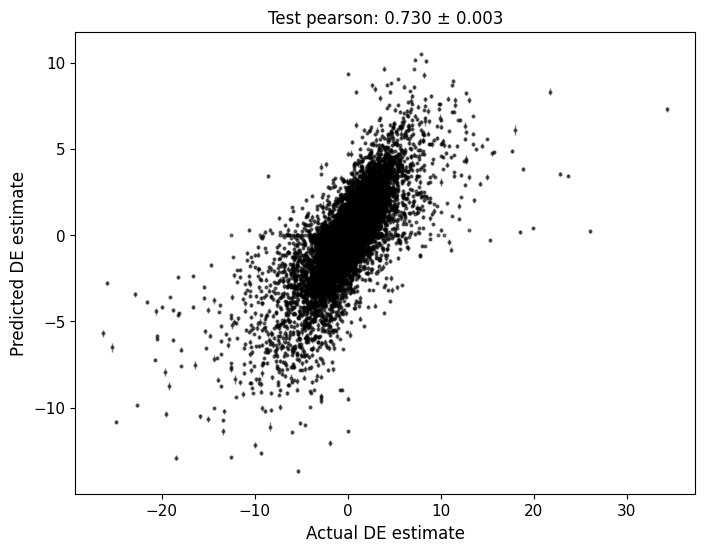

In [200]:
pl1 = p2t_model.plot_prediction(X_perturbs.fillna(0), y_target, plot_metric='pearson')

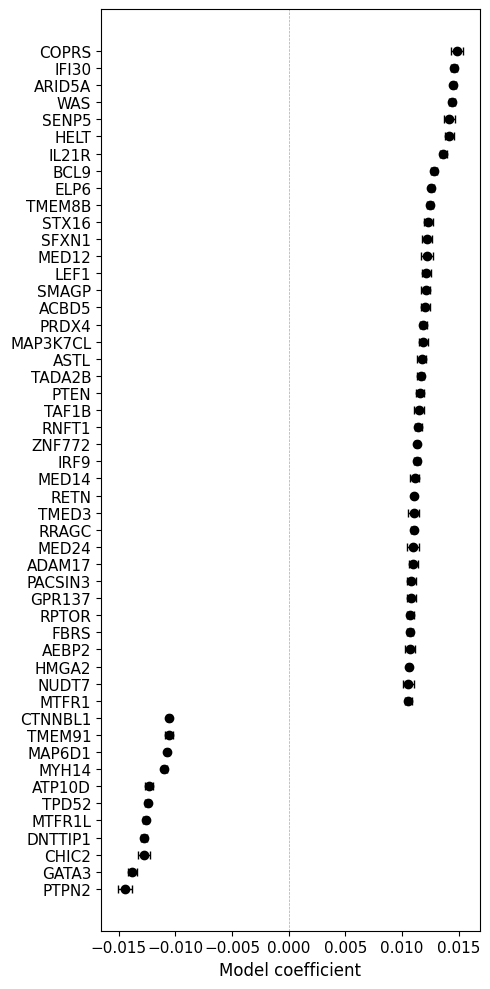

In [201]:
fig, ax = plt.subplots(figsize=(5,10))
p2t_model.plot_coefs(top_n=50, ax=ax, return_ax=True, show_labels=True)

plt.tight_layout()

In [202]:
pt_coef_Diff043 = p2t_model.get_coefs()

In [203]:
pt_coef_all = pt_coef_ota.copy()
pt_coef_all.columns = ['coef_mean_ota', 'coef_sem_ota']
pt_coef_all[['coef_mean_Diff043', 'coef_sem_Diff043']] = pt_coef_Diff043[['coef_mean', 'coef_sem']]

In [204]:
pt_coef_all[['coef_mean_Diff043', 'coef_sem_Diff043']] = pt_coef_Diff043[['coef_mean', 'coef_sem']]

In [205]:
pt_coef_all

coef_mean_ota  coef_sem_ota  coef_mean_Diff043  coef_sem_Diff043
ABHD5        -0.007189      0.000404          -0.004725          0.000151
TRIO         -0.001148      0.000390          -0.003947          0.000263
CDON          0.002401      0.000252          -0.003706          0.000155
ITCH         -0.004161      0.000589           0.003480          0.000222
COL16A1       0.000403      0.000363           0.010495          0.000413
...                ...           ...                ...               ...
ZNF442       -0.001516      0.000470           0.001526          0.000235
SERF1B        0.005131      0.000294          -0.000612          0.000143
NPTXR         0.002393      0.000627          -0.000539          0.000129
SLFN14        0.001916      0.000260          -0.003209          0.000237
H2AFJ        -0.003985      0.000543          -0.003437          0.000108

[11288 rows x 4 columns]

coef_mean_ota  coef_mean_Diff043
coef_mean_ota           1.000000           0.407031
coef_mean_Diff043       0.407031           1.000000

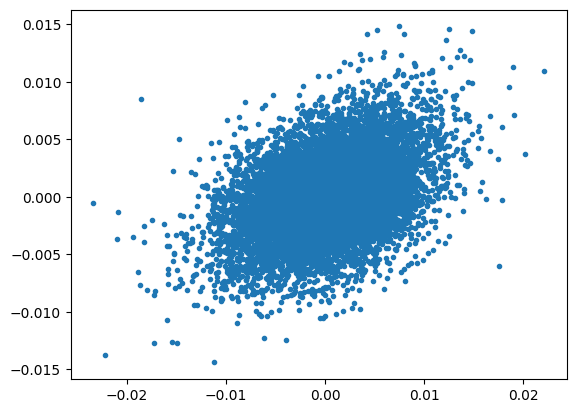

In [206]:
plt.plot(pt_coef_all['coef_mean_ota'], pt_coef_all['coef_mean_Diff043'], '.')
pt_coef_all[['coef_mean_ota', 'coef_mean_Diff043']].corr()

In [128]:
#pt_coef_all.to_csv('results/ota_vs_Diff043Rest_Th2_vs_Th1_regulators.csv')

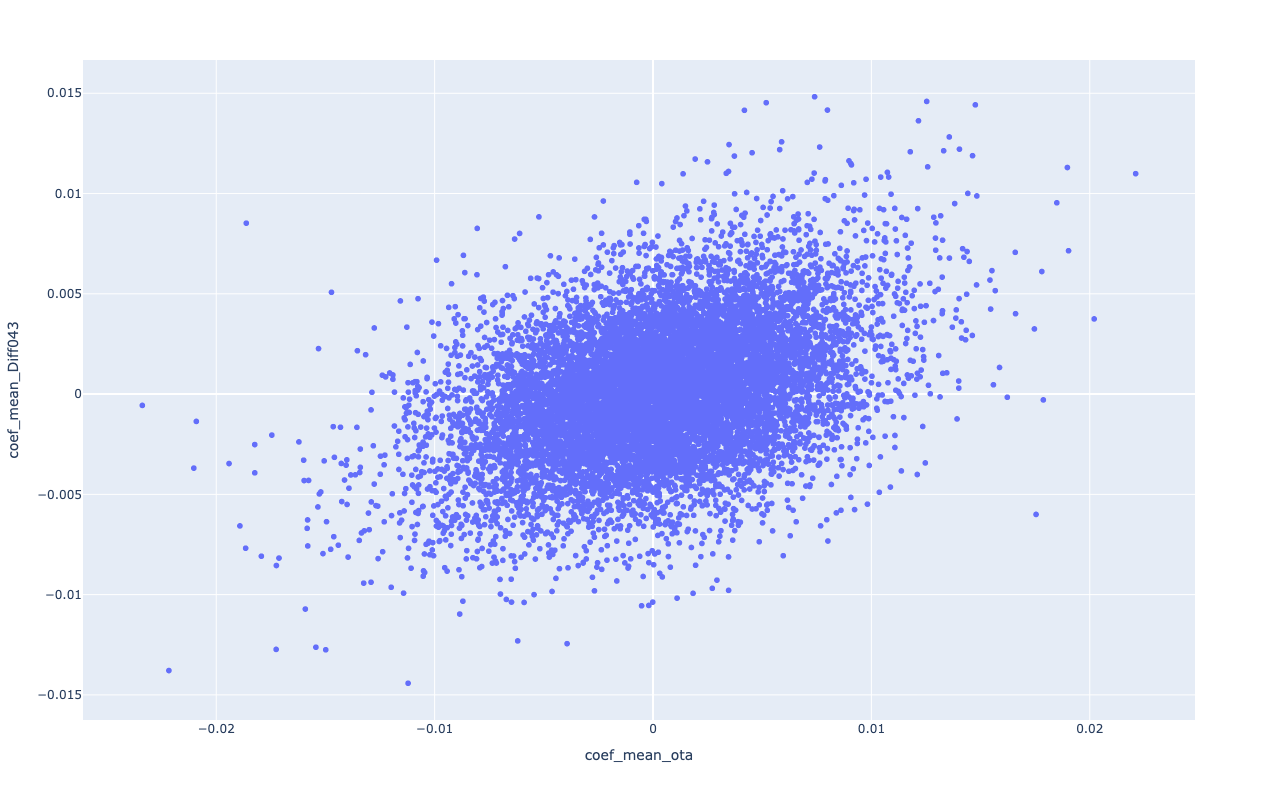

In [207]:
fig = px.scatter(
    pt_coef_all,
    x='coef_mean_ota',
    y='coef_mean_Diff043',
    hover_name=pt_coef_all.index,
    width=800,
    height=800,
    opacity=1,
)
fig.show()

([Text(-0.02140645032696324, -0.01240132617612188, 'GATA3'),
  Text(-0.0016567312806587409, -0.008119306472453819, 'IL4R'),
  Text(0.004981118028429467, 0.004736433147330563, 'STAT1'),
  Text(0.015699200260110888, -0.001469313696397894, 'IFNGR1'),
  Text(0.008960810581845474, 0.009125920559450582, 'IL5'),
  Text(0.005217265968485971, 0.002604281349558441, 'IL4'),
  Text(-0.005451857593731783, 0.00039078705508934983, 'STAT4'),
  Text(0.01787070998036224, 0.007615893896625356, 'TBX21'),
  Text(-0.003372942387972956, 0.005475964663374584, 'STAT6'),
  Text(0.01221034728013283, 0.002033510919995568, 'BACH2'),
  Text(0.009736201166211697, 0.007033481125764955, 'STAT3'),
  Text(0.009540531566385922, 0.011588718644062006, 'RASGRP1'),
  Text(0.016968345477696246, 0.004828732225164067, 'NLRP1'),
  Text(0.003624982099355356, -0.00025155177642807725, 'XBP1'),
  Text(0.0031370964550645614, -0.0026094100206369673, 'SETDB1'),
  Text(-0.0033675562804677886, 0.0025598631131473794, 'IFNGR2')],
 [Text(0.

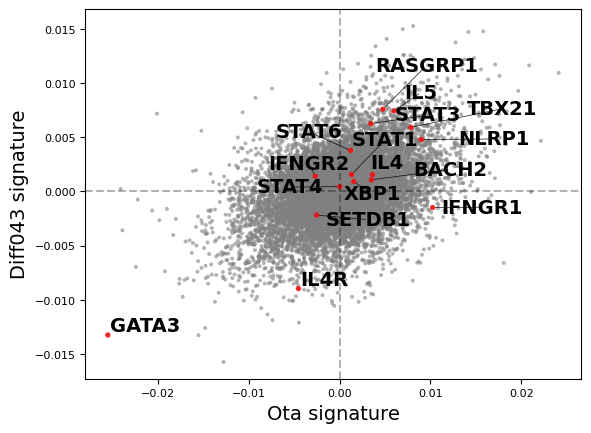

In [69]:
known_regulators = [
    'GATA3', 'IL4R', 'STAT1', 'IFNGR1', 'IKFZ1', 'IL5', 'IL4',
    'STAT4', 'TBX21', "STAT6", 'BACH2', 'STAT3',
    'RASGRP1', 'NLRP1', 'XBP1', 'SETDB1', 'IFNGR2'
]
ax = sns.scatterplot(data=pt_coef_all, x='coef_mean_ota', y='coef_mean_Diff043', color='grey', s=8, alpha=0.6, edgecolor='none')

# Add scatter points for known regulators in red
regulators = pt_coef_all[pt_coef_all.index.isin(known_regulators)]
sns.scatterplot(data=regulators, x='coef_mean_ota', y='coef_mean_Diff043', color='red', s=15,alpha=0.8, edgecolor='none', ax=ax)

# Add dotted lines at x=0 and y=0
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.3)

# Set larger font sizes for axis labels and ticks
ax.set_xlabel('Ota signature', fontsize=14)
ax.set_ylabel('Diff043 signature', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)

# Add annotations for known regulators using adjustText
from adjustText import adjust_text
texts = []
for gene in known_regulators:
    if gene in pt_coef_all.index:
        texts.append(ax.text(pt_coef_all.loc[gene, 'coef_mean_ota'], 
                           pt_coef_all.loc[gene, 'coef_mean_Diff043'],
                           gene,
                           fontsize=14,
                           weight='bold'))

# Adjust text positions to avoid overlaps
adjust_text(texts, 
           arrowprops=dict(arrowstyle='-', color='black', lw=0.5, alpha=0.9),
           expand_points=(1.5, 1.5))

In [130]:
adata_de

AnnData object with n_obs × n_vars = 33986 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target'
    var: 'gene_ids', 'gene_name', 'n_signif_effects_Stim8hr', 'n_signif_effects_Stim48hr', 'n_signif_effects_Rest'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [137]:
adata_de.obs

target_contrast_gene_name culture_condition  \
ENSG00000012963_Stim8hr                      UBR7           Stim8hr   
ENSG00000017260_Stim8hr                    ATP2C1           Stim8hr   
ENSG00000067606_Stim8hr                     PRKCZ           Stim8hr   
ENSG00000092929_Stim8hr                    UNC13D           Stim8hr   
ENSG00000100504_Stim8hr                      PYGL           Stim8hr   
...                                           ...               ...   
ENSG00000198342_Rest                       ZNF442              Rest   
ENSG00000205572_Rest                       SERF1B              Rest   
ENSG00000221890_Rest                        NPTXR              Rest   
ENSG00000236320_Rest                       SLFN14              Rest   
ENSG00000246705_Rest                        H2AFJ              Rest   

                         target_contrast chunk  n_cells_target  
ENSG00000012963_Stim8hr  ENSG00000012963     0           491.0  
ENSG00000017260_Stim8hr  ENSG00000017260     0           469.0  
ENSG00000067606_Stim8hr  ENSG00000067606     0           427.0  
ENSG00000092929_Stim8hr  ENSG00000092929     0           830.0  
ENSG00000100504_Stim8hr  ENSG00000100504     0           414.0  
...                                  ...   ...             ...  
ENSG00000198342_Rest     ENSG00000198342   680           324.0  
ENSG00000205572_Rest     ENSG00000205572   680            44.0  
ENSG00000221890_Rest     ENSG00000221890   680           293.0  
ENSG00000236320_Rest     ENSG00000236320   680           848.0  
ENSG00000246705_Rest     ENSG00000246705   680          1173.0  

[33986 rows x 5 columns]

In [139]:
adata_de[adata_de.obs.culture_condition=='Stim8hr'].obs.target_contrast_gene_name

ENSG00000012963_Stim8hr      UBR7
ENSG00000017260_Stim8hr    ATP2C1
ENSG00000067606_Stim8hr     PRKCZ
ENSG00000092929_Stim8hr    UNC13D
ENSG00000100504_Stim8hr      PYGL
                            ...  
ENSG00000198363_Stim8hr      ASPH
ENSG00000214013_Stim8hr      GANC
ENSG00000230657_Stim8hr      PRB4
ENSG00000251192_Stim8hr    ZNF674
ENSG00000278540_Stim8hr     ACACA
Name: target_contrast_gene_name, Length: 11416, dtype: category
Categories (11416, object): ['A1BG', 'A2M', 'AAAS', 'AACS', ..., 'ZXDC', 'ZYG11B', 'ZYX', 'ZZEF1']

In [227]:
#marker_gene = ['IFNG', 'IL4', 'IL5', 'IL13']
marker_zscore = adata_de[adata_de.obs.culture_condition=='Stim8hr', adata_de.var.gene_name.isin(marker_gene)].layers['zscore']
marker_zscore_df = pd.DataFrame(data=marker_zscore, 
                                index=adata_de[adata_de.obs.culture_condition=='Stim8hr'].obs.target_contrast_gene_name, 
                                columns=marker_gene)
marker_zscore_df.loc[marker_gene] = 0

In [228]:
test = pd.merge(pt_coef_all, marker_zscore_df, left_index=True, right_index=True)

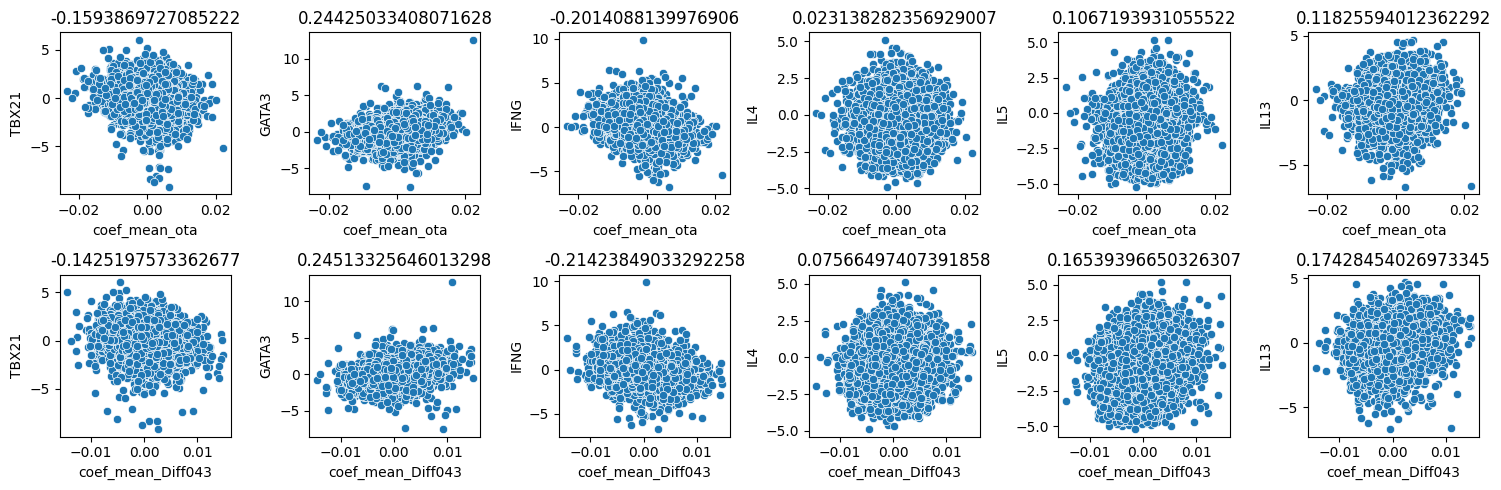

In [229]:
fig, ax = plt.subplots(2, 6, figsize=(15,5))
coef_label = ['coef_mean_ota', 'coef_mean_Diff043']
for i, col in enumerate(coef_label):
    for j, marker in enumerate(marker_gene):
        sns.scatterplot(test, x=col, y=marker, ax=ax[i,j])
        ax[i,j].set_title(pearsonr(test[col], test[marker])[0])

plt.tight_layout()

In [230]:
test

coef_mean_ota  coef_sem_ota  coef_mean_Diff043  coef_sem_Diff043  \
ABHD5        -0.007189      0.000404          -0.004725          0.000151   
TRIO         -0.001148      0.000390          -0.003947          0.000263   
CDON          0.002401      0.000252          -0.003706          0.000155   
ITCH         -0.004161      0.000589           0.003480          0.000222   
COL16A1       0.000403      0.000363           0.010495          0.000413   
...                ...           ...                ...               ...   
ZNF442       -0.001516      0.000470           0.001526          0.000235   
SERF1B        0.005131      0.000294          -0.000612          0.000143   
NPTXR         0.002393      0.000627          -0.000539          0.000129   
SLFN14        0.001916      0.000260          -0.003209          0.000237   
H2AFJ        -0.003985      0.000543          -0.003437          0.000108   

            TBX21     GATA3      IFNG       IL4       IL5      IL13  
ABHD5    0.179575 -0.347371 -0.375944 -1.092689 -3.069032 -0.282528  
TRIO     1.701945 -0.481060 -1.006430  0.169055 -1.998519  0.099467  
CDON     0.167796 -0.311006  1.847287 -1.598804 -3.517729 -0.706020  
ITCH     0.266118  1.879991  0.910874  0.069976  0.283396  1.242052  
COL16A1  0.148887  0.224803 -0.320822 -1.043702 -1.012125  0.166671  
...           ...       ...       ...       ...       ...       ...  
ZNF442  -0.256332 -0.530494 -1.969056 -1.829010  0.768495 -1.267123  
SERF1B   1.412252  0.627900 -2.092855 -2.311584 -2.900983 -1.050056  
NPTXR    0.426516  0.790986  1.369372 -2.483543  0.692755  0.320003  
SLFN14  -0.245412  1.055715  1.049527  0.769417 -0.307702  0.727357  
H2AFJ   -0.500386 -2.833623  4.430370 -0.528364 -1.772845 -0.651697  

[11232 rows x 10 columns]

In [243]:
test.loc[['IFI30', 'ZNF286B', 'WAS', 'TOR1A', 'MEAF6', 'BCL9', 'IL21R', 'MED24', 'PRDX4', 'IRF9', 'SMAGP', 'LEF1', 'PTPN2', 'MAP6D1']]

coef_mean_ota  coef_sem_ota  coef_mean_Diff043  coef_sem_Diff043  \
IFI30         0.012533      0.000415           0.014593          0.000265   
ZNF286B       0.006488      0.000793           0.008033          0.000453   
WAS           0.014760      0.000635           0.014423          0.000269   
TOR1A         0.009192      0.000539           0.010536          0.000203   
MEAF6         0.004574      0.000633           0.005087          0.000497   
BCL9          0.013567      0.000443           0.012822          0.000230   
IL21R         0.012158      0.000321           0.013627          0.000320   
MED24         0.022102      0.000669           0.010992          0.000518   
PRDX4         0.014632      0.000233           0.011888          0.000318   
IRF9          0.018976      0.000565           0.011299          0.000264   
SMAGP         0.011782      0.000260           0.012083          0.000407   
LEF1          0.013310      0.000748           0.012133          0.000397   
PTPN2        -0.011216      0.000286          -0.014419          0.000612   
MAP6D1       -0.015921      0.000529          -0.010719          0.000144   

            TBX21      GATA3      IFNG       IL4       IL5      IL13  
IFI30    0.013425   2.555318  0.782205  2.254578  4.205823  1.899333  
ZNF286B -0.615067   2.058059  0.450299  0.238748  5.167151  3.380423  
WAS     -1.908173   1.632035 -2.836151  0.780890  2.187296  1.262871  
TOR1A   -0.028420   4.618237 -0.866969  1.358716  3.979276  3.688384  
MEAF6    0.337413   1.960716 -2.397456 -2.396453  2.971820 -0.039283  
BCL9    -1.639851   2.118962 -1.737167  0.450115  1.529057  1.736099  
IL21R   -3.358658   0.274090 -0.448781  0.333082 -0.089576  1.707873  
MED24   -5.157317  12.618172 -5.435312 -2.605841 -2.253486 -6.647721  
PRDX4   -0.480089   1.681618  0.303633 -1.461571 -0.224052 -1.737142  
IRF9    -1.971727   2.515077 -0.813903  0.125828 -0.272698  0.585920  
SMAGP   -3.720101   1.983077 -1.775029  1.753955  3.525704  2.477601  
LEF1    -0.622457   1.592872 -2.318857  1.755167  0.152380  2.163597  
PTPN2    5.050001  -0.788323  3.615256 -1.937951 -3.230464 -1.956524  
MAP6D1   2.347845  -0.947516  1.297246  0.008108  0.005964 -0.720331

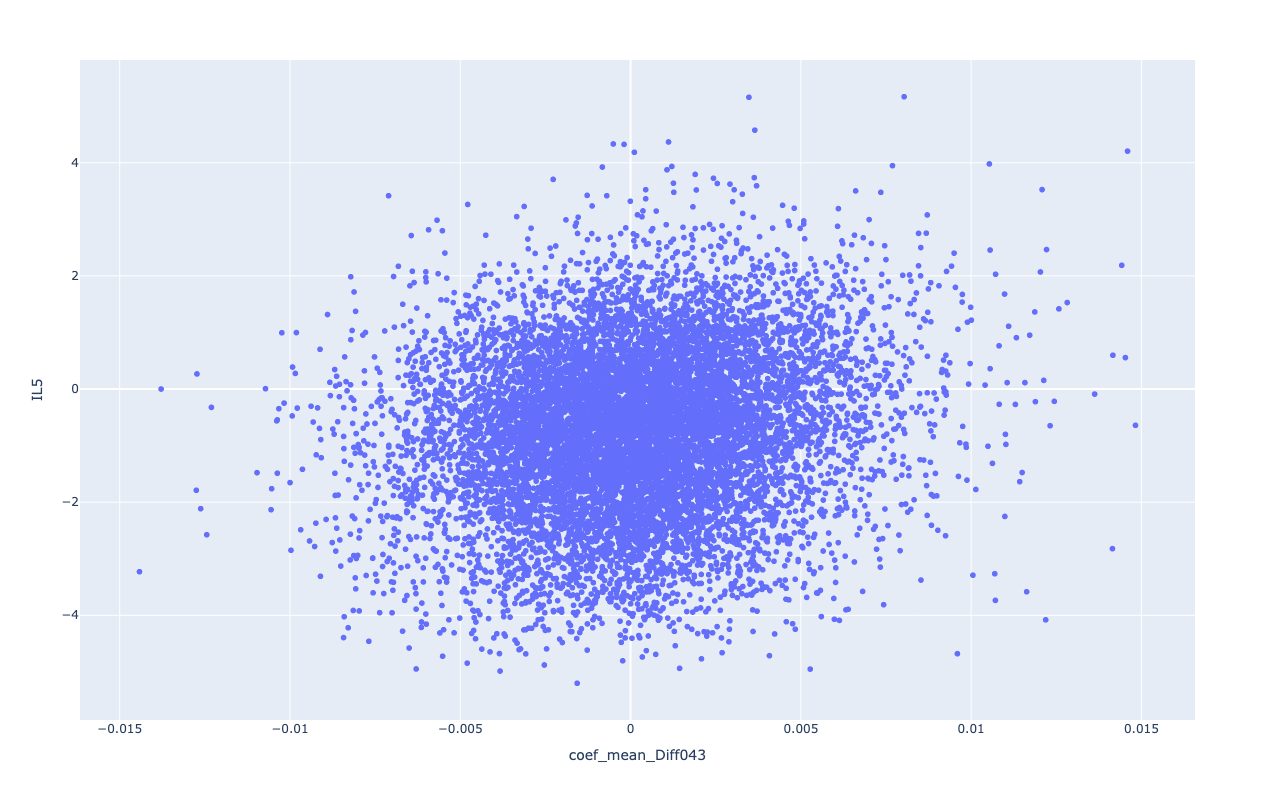

In [231]:
fig = px.scatter(
    test,
    x='coef_mean_Diff043',
    y='IL5',
    hover_name=test.index,
    width=800,
    height=800,
    opacity=1,
)
fig.show()

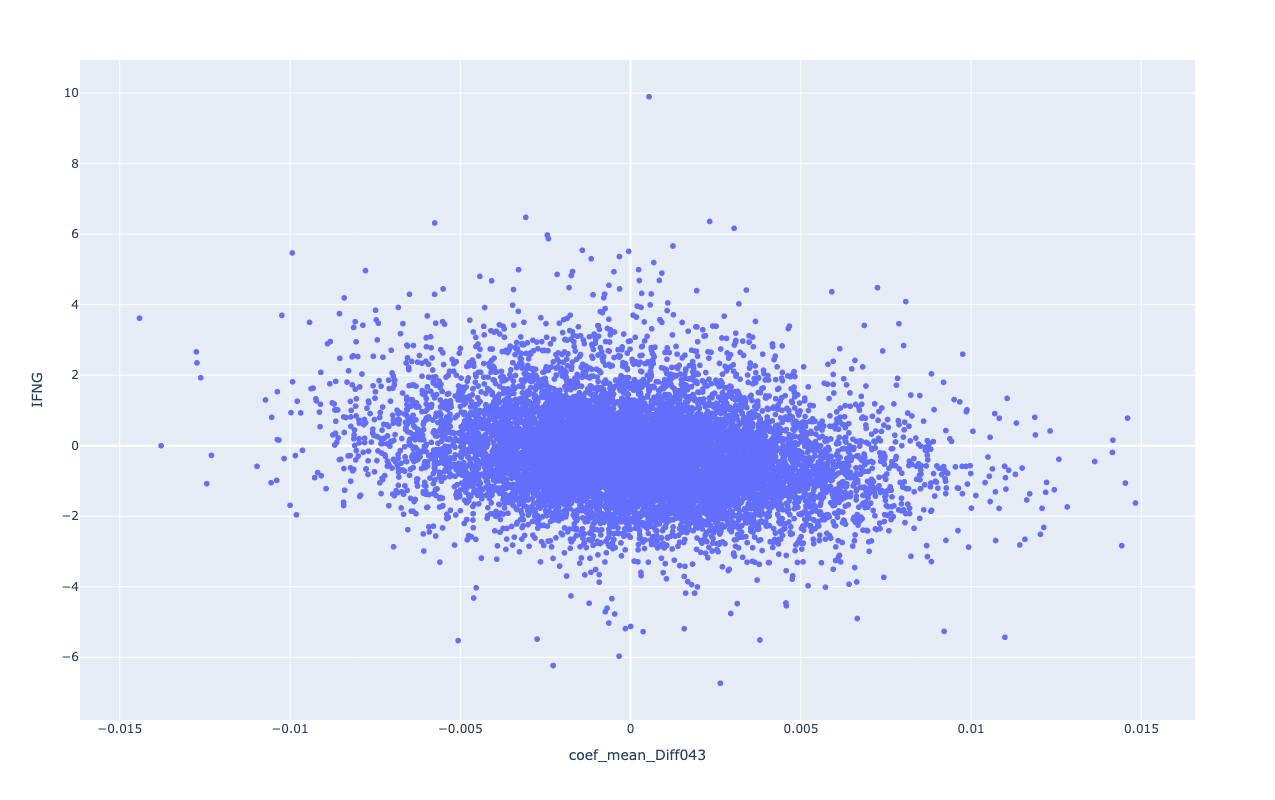

In [232]:
fig = px.scatter(
    test,
    x='coef_mean_Diff043',
    y='IFNG',
    hover_name=test.index,
    width=800,
    height=800,
    opacity=1,
)
fig.show()

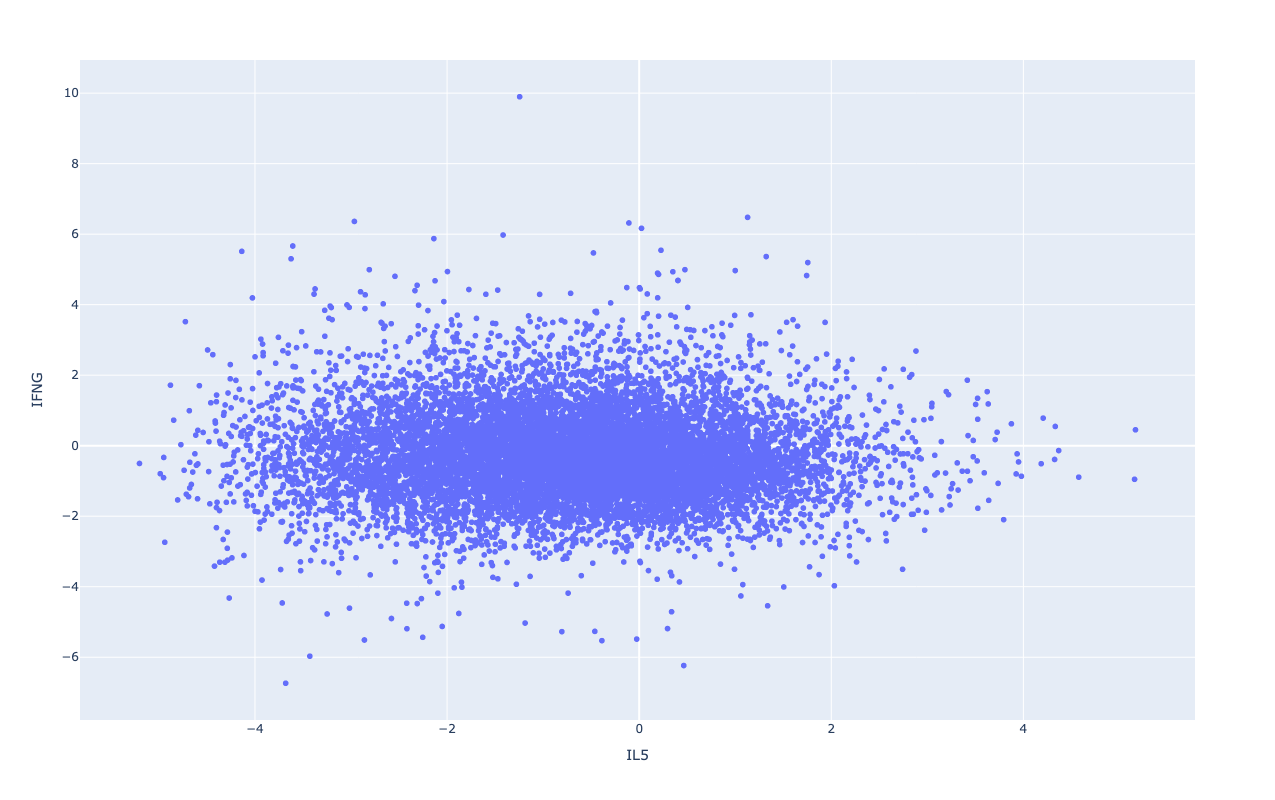

In [233]:
fig = px.scatter(
    test,
    x='IL5',
    y='IFNG',
    hover_name=test.index,
    width=800,
    height=800,
    opacity=1,
)
fig.show()

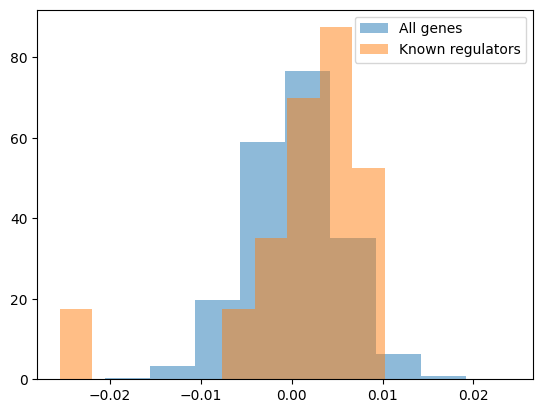

In [73]:
known_regulators = [
    'GATA3', 'IL4R', 'STAT1', 'IFNGR1', 'IL5', 'IL4',
    'STAT4', 'TBX21', "STAT6", 'BACH2', 'STAT3',
    'RASGRP1', 'NLRP1', 'XBP1', 'SETDB1', 'IFNGR2'
]
plt.hist(
    pt_coef_all['coef_mean_ota'].values,
    density=True,
    alpha=0.5,
    label='All genes'
)
plt.hist(
    pt_coef_all['coef_mean_ota'][known_regulators],
    density=True, 
    alpha=0.5,
    label='Known regulators'
)
plt.legend()

### Plot DE effects of predicted regulators

In [500]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

st = 'Th2'
top_quant = 0.003
alpha = 0.01

# Get DE genes with activation (Arce et al)
act_signature_df = pd.read_csv('Arce2024_20230130_DESeq2_output_AAVS1_Teff_Stimulation_vs_Resting.csv')
act_signature_df['zscore'] = act_signature_df['log2FoldChange']/act_signature_df['lfcSE']
activation_genes = act_signature_df[(act_signature_df['zscore'].abs() > 5) & (act_signature_df['padj'] < 0.01)]['gene_name']

# Get top DE genes for input signature
state_results_df = all_results_df[all_results_df['contrast'] == st]
pl_df = pd.merge(all_results_df, act_signature_df.rename({'zscore':'zscore_act', 'gene_name':'variable'}, axis=1)[['zscore_act', 'variable']])
state_results_df['activation_genes'] = state_results_df['variable'].isin(activation_genes)
signature_effect_size = state_results_df[state_results_df['adj_p_value'] < alpha].sort_values('zscore')
signature_gs = signature_effect_size.variable.tolist()

# Get top and bottom 10% of coefficient values
n = len(all_coefs['coef_mean'])
st_coefs = all_coefs[all_coefs['state'] == st].copy()
top_10_percent = st_coefs['coef_mean'].nlargest(int(n * top_quant))
bottom_10_percent = st_coefs['coef_mean'].nsmallest(int(n * top_quant))
predicted_effect_size = pd.concat([top_10_percent, bottom_10_percent]).sort_values(ascending=False)
predicted_regulators = predicted_effect_size.index.tolist()

# Get DE results and pivot to wide format
long_de_results = get_DE_results_long(adata_de, targets=predicted_regulators, genes=signature_gs, gene_id_col='gene_name')
long_de_results = long_de_results[long_de_results['culture_condition'] == 'Stim8hr'].copy()
wide_de_results = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='zscore')
wide_de_results_signif = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='adj_p_value')

# Create a mask for diagonal values and low zscore values
mask = pd.DataFrame(False, index=wide_de_results.index, columns=wide_de_results.columns)
for idx in wide_de_results.index:
    if idx in wide_de_results.columns:
        mask.loc[idx, idx] = True
# Add mask for abs zscore < 1
mask = mask | (wide_de_results.abs() < 0)
wide_de_results = wide_de_results.mask(mask, 0)
wide_de_results = wide_de_results.T

# Define axis labels
wide_de_results.index.name = 'Regulators (CRISPRi targets)'
wide_de_results.columns.name = f'{st} signature genes (5% FDR)'

/tmp/ipykernel_63633/131503189.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_results_df['activation_genes'] = state_results_df['variable'].isin(activation_genes)


<Figure size 2000x1500 with 0 Axes>

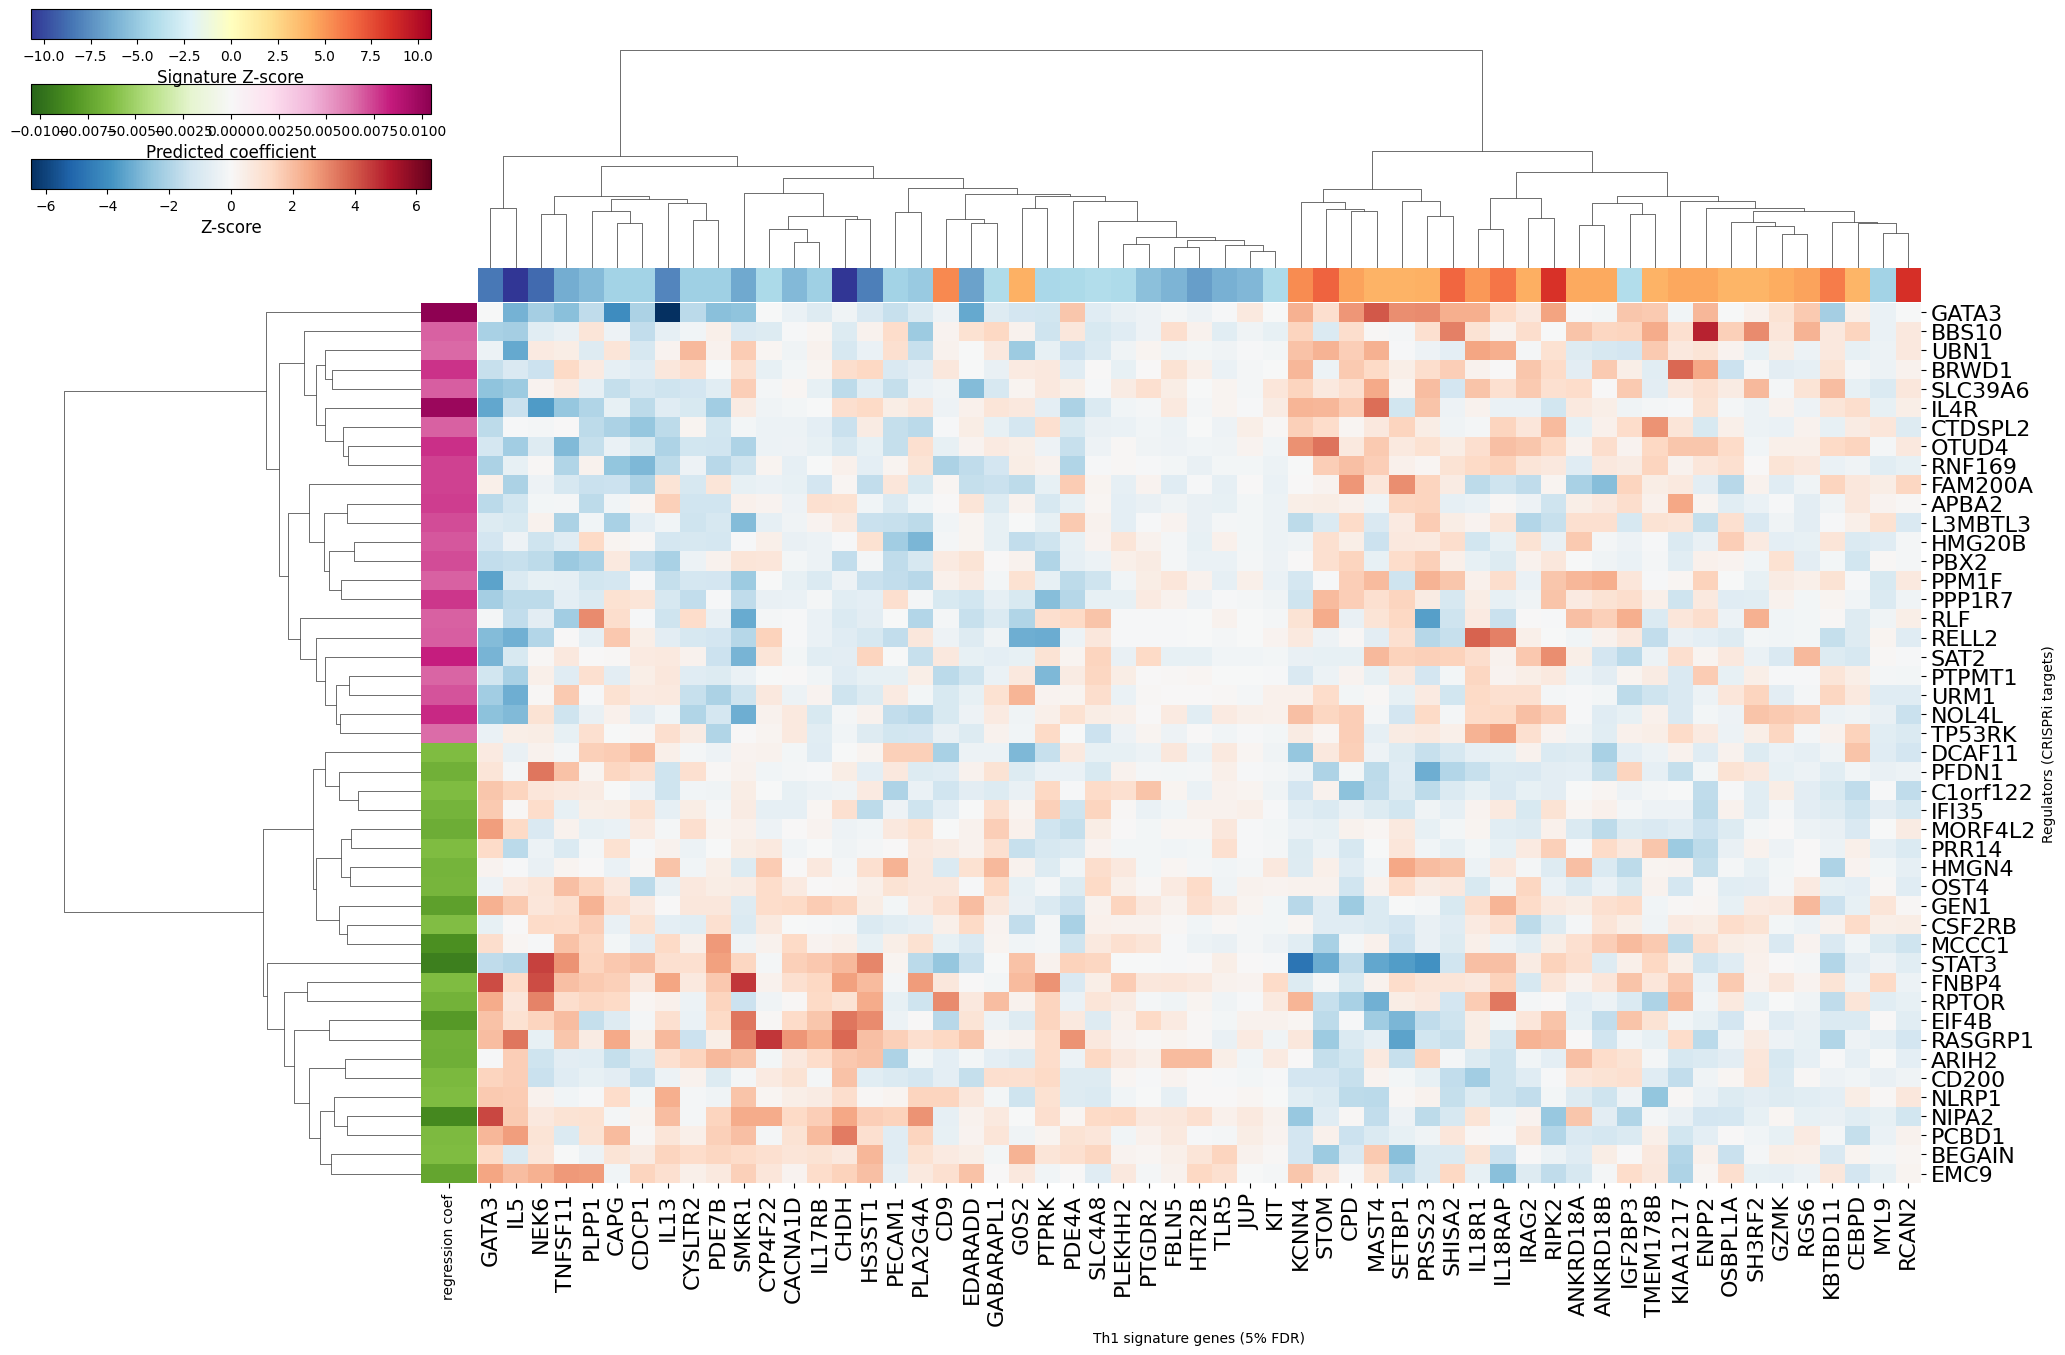

In [406]:
# Create row annotation dataframe with predicted effect sizes (now rows after transpose)
row_annot = pd.DataFrame({
    'regression coef': predicted_effect_size[wide_de_results.index]
})

# Create column annotation dataframe with signature zscores (now columns after transpose)
col_annot = pd.DataFrame({
    'zscore': signature_effect_size.set_index('variable').loc[wide_de_results.columns, 'zscore'],
    'activation_gene': signature_effect_size.set_index('variable').loc[wide_de_results.columns, 'activation_genes']
})

# Create different color maps for annotations
cmap_row = plt.cm.PiYG_r    # Pink-Yellow-Green for row annotation (predicted effect size)
cmap_col = plt.cm.RdYlBu_r  # Red-Yellow-Blue for column annotation (signature zscore)
cmap_activation = plt.cm.binary  # Binary colormap for activation genes

# Center the colormaps at 0 by using symmetric vmin/vmax
vmax_row = max(abs(row_annot['regression coef'].min()), abs(row_annot['regression coef'].max()))
vmax_col = max(abs(col_annot['zscore'].min()), abs(col_annot['zscore'].max()))
# Create color series for annotations (seaborn expects Series, not DataFrame with RGBA)
row_colors = row_annot['regression coef'].apply(lambda x: cmap_row((x + vmax_row) / (2 * vmax_row)))
col_colors = col_annot['zscore'].apply(lambda x: cmap_col((x + vmax_col) / (2 * vmax_col)))
activation_colors = col_annot['activation_gene'].apply(lambda x: cmap_activation(1.0 if x else 0.0))

# Create the clustermap
plt.figure(figsize=(20, 15))
g = sns.clustermap(wide_de_results,
                   cmap='RdBu_r',
                   center=0,
                   row_cluster=True,
                   col_cluster=True,
                   xticklabels=True,
                   yticklabels=True,
                   method='ward',
                   figsize=(20, 15),
                   row_colors=row_colors,
                   col_colors=[col_colors],
                   cbar_pos=None)

# Adjust layout to make room for additional colorbars
plt.subplots_adjust(top=0.85)

# Add colorbars for annotations - all same width and height
colorbar_width = 0.2
colorbar_height = 0.02
colorbar_left = 0

# Main heatmap colorbar - bottom
cbar_ax_main = g.fig.add_axes([colorbar_left, 0.75, colorbar_width, colorbar_height])
vmax_main = max(abs(wide_de_results.min().min()), abs(wide_de_results.max().max()))
sm_main = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-vmax_main, vmax=vmax_main))
sm_main.set_array([])
cbar_main = plt.colorbar(sm_main, cax=cbar_ax_main, orientation='horizontal')
cbar_main.set_label('Z-score', fontsize=12)

# Row annotation colorbar (predicted effect size)
cbar_ax_row = g.fig.add_axes([colorbar_left, 0.80, colorbar_width, colorbar_height])
sm_row = plt.cm.ScalarMappable(cmap=cmap_row, norm=plt.Normalize(vmin=-vmax_row, vmax=vmax_row))
sm_row.set_array([])
cbar_row = plt.colorbar(sm_row, cax=cbar_ax_row, orientation='horizontal')
cbar_row.set_label('Predicted coefficient', fontsize=12)

# Column annotation colorbar (signature zscore)
cbar_ax_col = g.fig.add_axes([colorbar_left, 0.85, colorbar_width, colorbar_height])
sm_col = plt.cm.ScalarMappable(cmap=cmap_col, norm=plt.Normalize(vmin=-vmax_col, vmax=vmax_col))
sm_col.set_array([])
cbar_col = plt.colorbar(sm_col, cax=cbar_ax_col, orientation='horizontal')
cbar_col.set_label('Signature Z-score', fontsize=12)

# # Activation gene colorbar
# cbar_ax_activation = g.fig.add_axes([colorbar_left, 0.90, colorbar_width, colorbar_height])
# sm_activation = plt.cm.ScalarMappable(cmap=cmap_activation, norm=plt.Normalize(vmin=0, vmax=1))
# sm_activation.set_array([])
# cbar_activation = plt.colorbar(sm_activation, cax=cbar_ax_activation, orientation='horizontal')
# cbar_activation.set_label('Activation Gene', fontsize=12)
cbar_col.set_label('Signature Z-score', fontsize=12)

# Rotate x-axis labels
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center', fontsize=16)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=16)

plt.show()

In [352]:
st = 'Th1'
p2t_model,  X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()

### Test prediction with individual regulators

In [410]:
# Mask effects in cis and based on zscore thresh
X_perturbs_masked = X_perturbs.copy()
mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
# Mask cis effects
for idx in X_perturbs_masked.index:
    if idx in X_perturbs_masked.columns:
        mask.loc[idx, idx] = True
X_perturbs_masked = X_perturbs_masked.mask(mask)
# Impute masked values with column means
X_perturbs_masked = X_perturbs_masked.fillna(0)

# Train model on CD4 cells
all_evals = []
print(f"Training CD4 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
for r in tqdm(predicted_regulators, desc="Training models for regulators"):
    p2t_model = Perturb2StateModel(pca_transform=False, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
    p2t_model.fit(X_perturbs_masked[[r]], y_target, model_id=f'{cond}_{r}')
    ev = p2t_model.summarize_eval()
    all_evals.append(ev)


Training CD4 model with 60 PCs, 5 splits, 1 repeats


Training models for regulators: 100%|██████████| 46/46 [00:57<00:00,  1.26s/it]


In [414]:
p2t_model = Perturb2StateModel(pca_transform=False, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
p2t_model.fit(X_perturbs_masked[predicted_regulators], y_target, model_id=f'{cond}_all')
ev = p2t_model.summarize_eval()
all_evals.append(ev)

/tmp/ipykernel_63633/4023652259.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sorted_data, x='model_id', y='test_pearson',


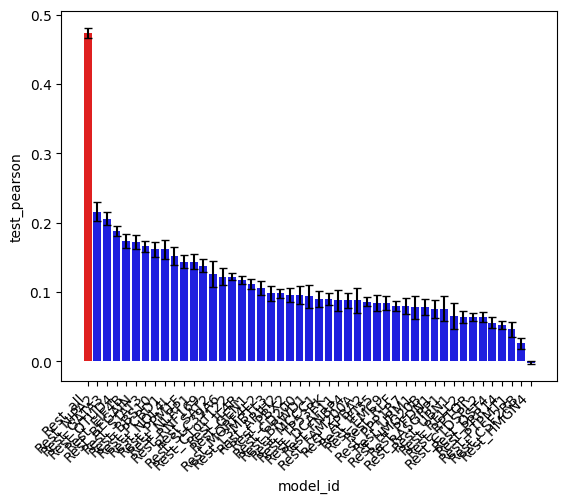

In [425]:
all_evals_df = pd.concat(all_evals)
# Sort data by test_pearson value
sorted_data = all_evals_df.sort_values('test_pearson', ascending=False).reset_index()

# Create barplot
ax = sns.barplot(data=sorted_data, x='model_id', y='test_pearson',
                palette=['red' if x == f'{cond}_all' else 'blue' for x in sorted_data['model_id']])

# Add error bars manually
x_coords = np.arange(len(sorted_data))
plt.errorbar(x=x_coords, y=sorted_data['test_pearson'],
            yerr=sorted_data['test_pearson_se'],
            fmt='none', color='black', capsize=3);

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right');

### Specificity

In [441]:
degs_y

variable
IL5      -1.0
CHDH     -1.0
IFNG      1.0
NEK6     -1.0
RCAN2     1.0
         ... 
LGALS9   -1.0
IL1R1     1.0
FN1       1.0
EMID1    -1.0
IL7R      1.0
Name: zscore, Length: 163, dtype: float64

In [494]:
(state_results_df.adj_p_value >= 0.1).astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
9995    1
9996    1
9997    1
9998    1
9999    1
Name: adj_p_value, Length: 10000, dtype: int64

In [501]:
for f in predicted_regulators:
    print(f)

SEC63
DDRGK1
DNAJB9
UFM1
CARM1
DCAF1
GEN1
GPR171
OST4
CD200
GALNT2
ACLY
SETDB1
SMARCB1
SLC25A37
C1orf122
UBA5
GDAP1
ZNF554
MYO9A
PDIA6
HS1BP3
AKIRIN1
PTPMT1
XBP1
TBPL1
C11orf58
TRMT6
CHD4
OTUD4
ANKRD11
DYRK4
NAB2
TP53RK
ENTR1
XRN1
L3MBTL3
URM1
MTM1
ADAT2
BRWD1
WARS
APBA2
CDKAL1
STAT6
IL4R


In [495]:
def calculate_tpr_fpr(all_results_df, adata_de, st='Th1', r='IL4R', cond='Stim8hr'):
    """Calculate true positive and false positive rates for matching signs between state and perturbation effects.
    
    Args:
        all_results_df: DataFrame with state results
        adata_de: AnnData object with perturbation results
        st: State to analyze (default 'Th1')
        r: Target gene (default 'IL4R') 
        cond: Culture condition (default 'Stim8hr')
        
    Returns:
        DataFrame with tpr and fpr values
    """
    # Get state results
    state_results_df = all_results_df[all_results_df['contrast'] == st].set_index('variable')
    degs_y = (state_results_df.adj_p_value >= 0.1).astype(int)

    # Get perturbation results
    long_pseq_results = get_DE_results_long(adata_de, targets=[r], gene_id_col='gene_name')
    long_pseq_results = long_pseq_results[long_pseq_results.culture_condition == cond].set_index('gene_name')
    degs_x = long_pseq_results['significant'].astype(int)

    # Get common genes and filter
    common_gs = np.intersect1d(degs_x.index, degs_y.index)
    degs_x = degs_x[common_gs]
    degs_y = degs_y[common_gs]

    # Calculate rates
    true_pos = sum((degs_x == degs_y) & (degs_y != 0))
    false_neg = sum((degs_x != degs_y) & (degs_y != 0))
    true_neg = sum((degs_x == degs_y) & (degs_y == 0))
    false_pos = sum((degs_x != degs_y) & (degs_y == 0))
    
    tpr = true_pos / (true_pos + false_neg)
    fpr = false_pos / (false_pos + true_neg)
    precision = true_pos / (true_pos + false_pos)
    
    return pd.DataFrame({'tpr': [tpr], 'fpr': [fpr], 'precision':[precision]})


all_res = []
from tqdm import tqdm
for r in tqdm(predicted_regulators, desc="Calculating TPR/FPR"):
    res = calculate_tpr_fpr(all_results_df, adata_de, st='Th1', r=r, cond='Stim8hr')
    all_res.append(res)


Calculating TPR/FPR: 100%|██████████| 46/46 [00:58<00:00,  1.26s/it]


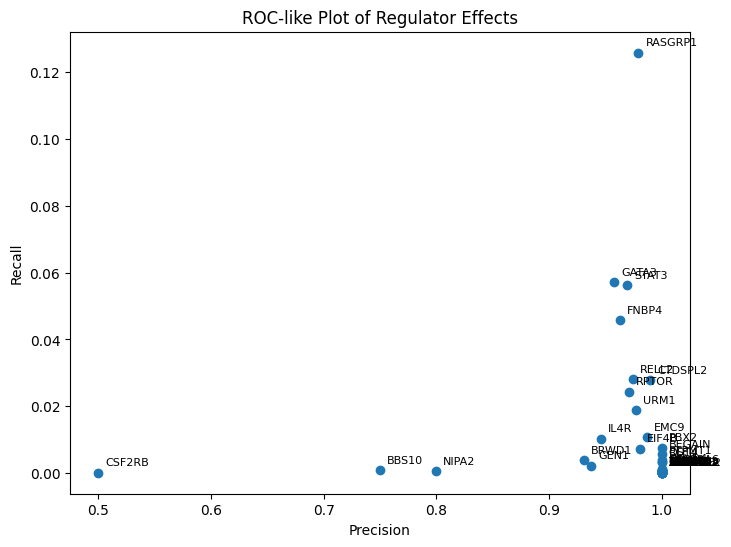

In [496]:
tpr_df = pd.concat(all_res)
tpr_df.index = predicted_regulators
plt.figure(figsize=(8,6))
scatter = plt.scatter(tpr_df['precision'], tpr_df['tpr'])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('ROC-like Plot of Regulator Effects')

# Annotate points with gene names
for gene in tpr_df.index:
    plt.annotate(gene, 
                (tpr_df.loc[gene, 'precision'], tpr_df.loc[gene, 'tpr']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8)

plt.show()

In [483]:
r = 'STAT3'
long_pseq_results = get_DE_results_long(adata_de, targets=[r], gene_id_col='gene_name')
long_pseq_results = long_pseq_results[long_pseq_results.culture_condition == cond].set_index('gene_name')
long_pseq_results['zscore'] = np.where(~long_pseq_results['significant'], 0, long_pseq_results['zscore'])
degs_x = np.sign(long_pseq_results['zscore'])

In [490]:
degs_y

variable
A4GALT    0.0
AAAS      0.0
AACS      0.0
AAK1      0.0
AAMDC     0.0
         ... 
ZWILCH    0.0
ZWINT     0.0
ZYG11A    0.0
ZYX       0.0
ZZEF1     0.0
Name: zscore, Length: 6985, dtype: float64

In [489]:
long_pseq_results[long_pseq_results['significant']]

index    gene    log_fc    zscore  adj_p_value  \
gene_name                                                                     
ABCC1      ENSG00000168610_Stim8hr   ABCC1  0.260542  3.065559     0.049715   
ABHD2      ENSG00000168610_Stim8hr   ABHD2  0.573612  2.806012     0.080653   
ABTB2      ENSG00000168610_Stim8hr   ABTB2  1.313869  3.920038     0.005173   
ACOX1      ENSG00000168610_Stim8hr   ACOX1  0.474854  3.170972     0.040651   
ACVR1B     ENSG00000168610_Stim8hr  ACVR1B -2.109128 -3.228161     0.036412   
...                            ...     ...       ...       ...          ...   
ZNF282     ENSG00000168610_Stim8hr  ZNF282 -0.482092 -2.947881     0.063021   
ZNF410     ENSG00000168610_Stim8hr  ZNF410 -0.319559 -3.682154     0.011060   
ZNF552     ENSG00000168610_Stim8hr  ZNF552  0.556947  3.085184     0.048087   
ZNRF1      ENSG00000168610_Stim8hr   ZNRF1 -1.520318 -4.030769     0.003578   
ZZEF1      ENSG00000168610_Stim8hr   ZZEF1  0.414311  3.567087     0.014487   

           significant culture_condition  target_contrast  \
gene_name                                                   
ABCC1             True           Stim8hr  ENSG00000168610   
ABHD2             True           Stim8hr  ENSG00000168610   
ABTB2             True           Stim8hr  ENSG00000168610   
ACOX1             True           Stim8hr  ENSG00000168610   
ACVR1B            True           Stim8hr  ENSG00000168610   
...                ...               ...              ...   
ZNF282            True           Stim8hr  ENSG00000168610   
ZNF410            True           Stim8hr  ENSG00000168610   
ZNF552            True           Stim8hr  ENSG00000168610   
ZNRF1             True           Stim8hr  ENSG00000168610   
ZZEF1             True           Stim8hr  ENSG00000168610   

          target_contrast_gene_name  
gene_name                            
ABCC1                         STAT3  
ABHD2                         STAT3  
ABTB2                         STAT3  
ACOX1                         STAT3  
ACVR1B                        STAT3  
...                             ...  
ZNF282                        STAT3  
ZNF410                        STAT3  
ZNF552                        STAT3  
ZNRF1                         STAT3  
ZZEF1                         STAT3  

[502 rows x 9 columns]

variable
IL5      -1.0
CHDH     -1.0
IFNG      1.0
NEK6     -1.0
RCAN2     1.0
         ... 
LGALS9   -1.0
IL1R1     1.0
FN1       1.0
EMID1    -1.0
IL7R      1.0
Name: zscore, Length: 163, dtype: float64

In [393]:
p2t_model.get_prediction(X_perturbs)['pred_mean'].loc['RCAN2']

1.0967519708525324

In [399]:
pred_effect.sort_values()

target_contrast_gene_name
C2CD4D     -0.014864
NOL4L      -0.012751
FAIM       -0.009820
PHTF2      -0.008732
ATL3       -0.008453
              ...   
LAT2        0.011613
NIPA2       0.011886
C1orf122    0.012239
FAM200A     0.013647
MCCC1       0.013741
Name: pred_mean, Length: 3861, dtype: float64

In [404]:
pred_effect.sort_values()

target_contrast_gene_name
CCAR2    -0.018933
ZNF92    -0.017845
VAMP7    -0.017169
GDAP1    -0.016994
LETMD1   -0.016668
            ...   
GATA3     0.021374
WRN       0.022866
NSG1      0.023042
NIPA2     0.023703
SAT2      0.027355
Name: pred_mean, Length: 3861, dtype: float64

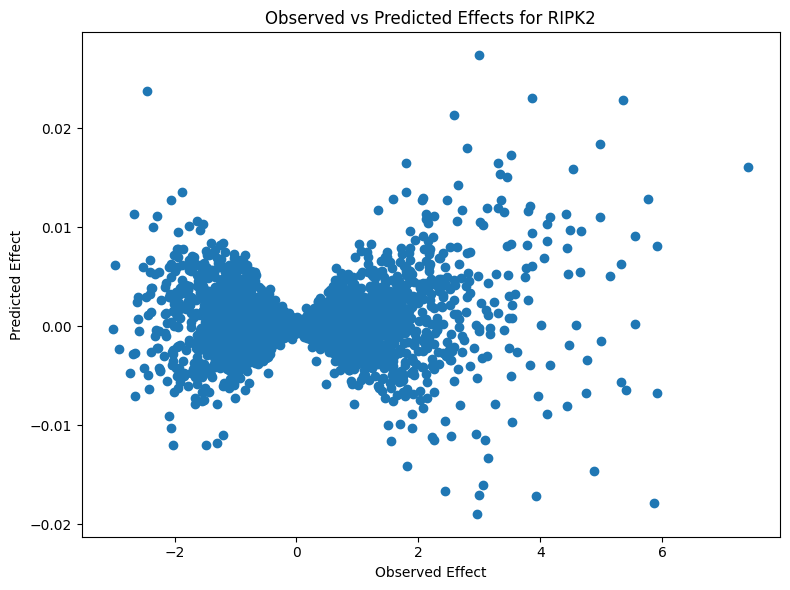

In [402]:
g = 'RIPK2'
pred_effect = p2t_model.get_effect_per_gene(X_perturbs, g)['pred_mean']
obs_effect = X_perturbs.loc[g]

plt.figure(figsize=(8,6))
plt.scatter(obs_effect, pred_effect)
plt.xlabel('Observed Effect')
plt.ylabel('Predicted Effect') 
plt.title(f'Observed vs Predicted Effects for {g}')

plt.tight_layout()
plt.show()

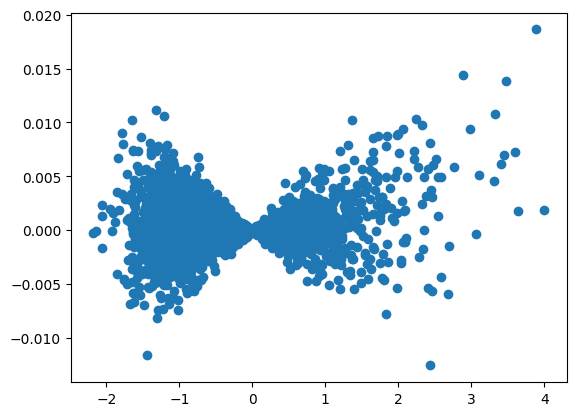

In [357]:
coefs = p2t_model.get_coefs()['coef_mean']
plt.scatter(X_perturbs.loc['RCAN2'], X_perturbs.loc['RCAN2'] * coefs)

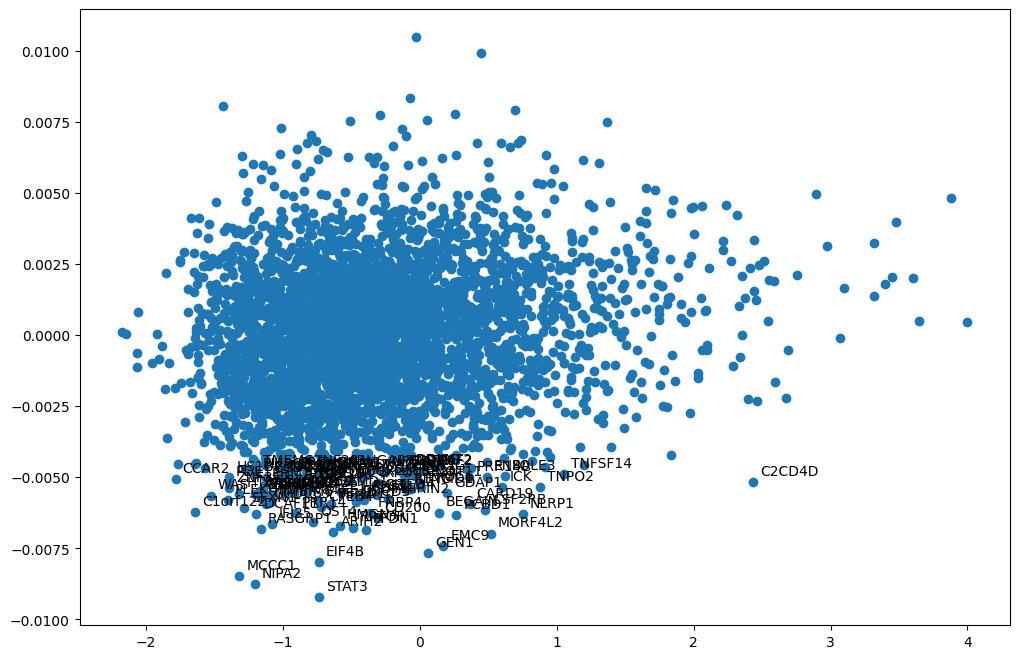

In [341]:
# Get top 5 genes with highest RCAN2 perturbation values
top_genes = p2t_model.get_coefs()['coef_mean'].nsmallest(100)

plt.figure(figsize=(12, 8))
plt.scatter(
    X_perturbs.loc['RCAN2'],
    p2t_model.get_coefs()['coef_mean'])

# Annotate top genes
for gene, value in top_genes.items():
    plt.annotate(
        gene,
        (X_perturbs.loc['RCAN2'][gene], value),
        xytext=(5, 5),
        textcoords='offset points'
    )

In [346]:
pred_df = p2t_model.get_prediction(X_perturbs, subset_regulators=[ 'MCCC1', 'NIPA2', 'STAT3', ''])
pred_df.loc['RCAN2']

pred_mean    0.031200
pred_sem     0.000378
Name: RCAN2, dtype: float64

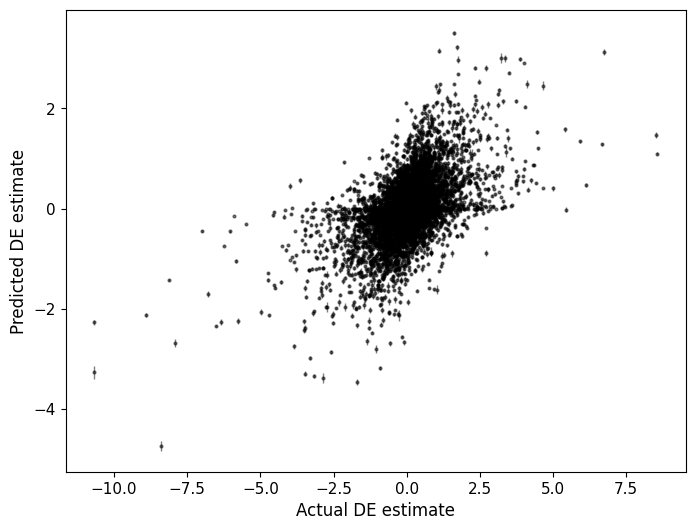

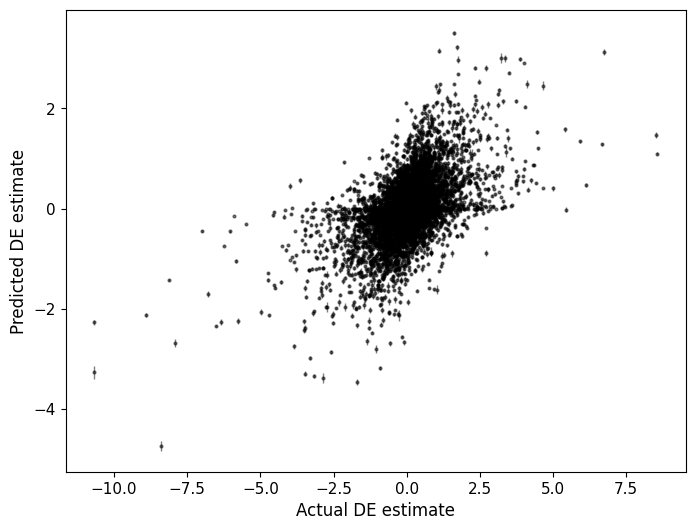

In [351]:
p2t_model.plot_prediction(X_perturbs, y_target)

In [340]:
p2t_model.plot_prediction(X_perturbs)


pred_mean    1.096752
pred_sem     0.033049
Name: RCAN2, dtype: float64

In [293]:
model_coefs = p2t_model.get_coefs()['coef_mean'].values

model_coefs

np.matmul(X_perturbs.loc['RCAN2'], model_coefs)


-1.1357412175172898

In [28]:
# Get the reordered indices after clustering
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# Get the original row and column names in clustered order
clustered_row_names = wide_de_results.index[row_order]
clustered_col_names = wide_de_results.columns[col_order]

# Get the linkage matrices for further cluster analysis
row_linkage = g.dendrogram_row.linkage
col_linkage = g.dendrogram_col.linkage

# Optional: Get specific number of clusters using scipy
from scipy.cluster.hierarchy import fcluster

# Example: Get 3 clusters for rows and columns
n_row_clusters = 10
n_col_clusters = 5

row_clusters = fcluster(row_linkage, n_row_clusters, criterion='maxclust')
col_clusters = fcluster(col_linkage, n_col_clusters, criterion='maxclust')

# Create DataFrames with cluster assignments
row_cluster_df = pd.DataFrame({
    'regulator': clustered_row_names,
    'cluster': row_clusters
})

col_cluster_df = pd.DataFrame({
    'gene': clustered_col_names, 
    'cluster': col_clusters
})

print("Row clusters:")
print(row_cluster_df.groupby('cluster')['regulator'].apply(list))
print("\nColumn clusters:")
print(col_cluster_df.groupby('cluster')['gene'].apply(list))

Row clusters:
cluster
1     [RLF, TP53RK, IL4R, STAT3, FNBP4, BEGAIN, RPTO...
2     [SAMD1, SAT2, PPM1F, METTL15, UBN1, OTUD4, EIF...
3                         [ATL3, HMG20B, LETMD1, PFDN1]
4          [RELL2, OXA1L, GATA3, NLRP1, CD200, MORF4L2]
5                                              [TLNRD1]
6                                       [HS1BP3, CPEB4]
7     [ZFP41, MYO1D, FAM200A, ABTB2, APBA2, BRMS1, R...
8                                               [HMGN4]
9        [L3MBTL3, NOL4L, FAM98B, RIOK3, CSF2RB, IFI35]
10    [PPP1R7, PBX2, WARS, PTPMT1, URM1, ADORA2A, BB...
Name: regulator, dtype: object

Column clusters:
cluster
1    [CAMK2D, IL5, SMKR1, FGFBP2, GZMK, PDE4A, DUSP...
2    [SETBP1, HBEGF, TANK, MIOS, SH3RF2, ANKRD18B, ...
3    [KCNN4, TNFRSF1A, RIPK2, GZMH, ANKRD18A, RXRA,...
4    [KBTBD11, CPD, KIAA1217, RCAN2, RGS6, RNASE6, ...
5    [PRSS23, STOM, MAST4, IL18R1, IL18RAP, IRAG2, ...
Name: gene, dtype: object


### Test reconstruction accuracy for different subsets of regulators 

In [191]:

y = y_target
pred_y = p2t_model.get_prediction(X_perturbs[subset_regs])['pred_mean']
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y, pred_y)
shrink_adjusted_error = np.abs(pred_y - (y*slope + intercept))
pd.concat[shrink_adjusted_error]

A4GALT    0.001190
AAAS      0.005428
AACS      0.001732
AAK1      0.004338
AAMDC     0.013968
            ...   
ZWILCH    0.008858
ZWINT     0.003676
ZYG11A    0.008459
ZYX       0.020162
ZZEF1     0.000970
Length: 6985, dtype: float64

Cluster 2 regulators: ['SAMD1', 'SAT2', 'PPM1F', 'METTL15', 'UBN1', 'OTUD4', 'EIF4B', 'GEN1', 'ARIH2', 'XYLT2', 'PRR14', 'DCAF11', 'TMBIM6']
Cluster 9 regulators: ['L3MBTL3', 'NOL4L', 'FAM98B', 'RIOK3', 'CSF2RB', 'IFI35']
Cluster 7 regulators: ['ZFP41', 'MYO1D', 'FAM200A', 'ABTB2', 'APBA2', 'BRMS1', 'RASGRP1', 'SFXN1', 'NIPA2']
Cluster 10 regulators: ['PPP1R7', 'PBX2', 'WARS', 'PTPMT1', 'URM1', 'ADORA2A', 'BBS10', 'RTRAF', 'BRWD1', 'NSG1', 'CTDSPL2', 'SLC39A6', 'RNF169', 'ANKRD26', 'EMC9', 'PCBD1', 'CBLB', 'AKIRIN2', 'OST4', 'OTUD7B']
Cluster 1 regulators: ['RLF', 'TP53RK', 'IL4R', 'STAT3', 'FNBP4', 'BEGAIN', 'RPTOR', 'PSMD10', 'HS2ST1', 'C1orf122', 'MAP3K6', 'MCCC1', 'COP1', 'PDCD5']
Cluster 3 regulators: ['ATL3', 'HMG20B', 'LETMD1', 'PFDN1']
Cluster 4 regulators: ['RELL2', 'OXA1L', 'GATA3', 'NLRP1', 'CD200', 'MORF4L2']
Cluster 5 regulators: ['TLNRD1']
Cluster 6 regulators: ['HS1BP3', 'CPEB4']
Cluster 8 regulators: ['HMGN4']


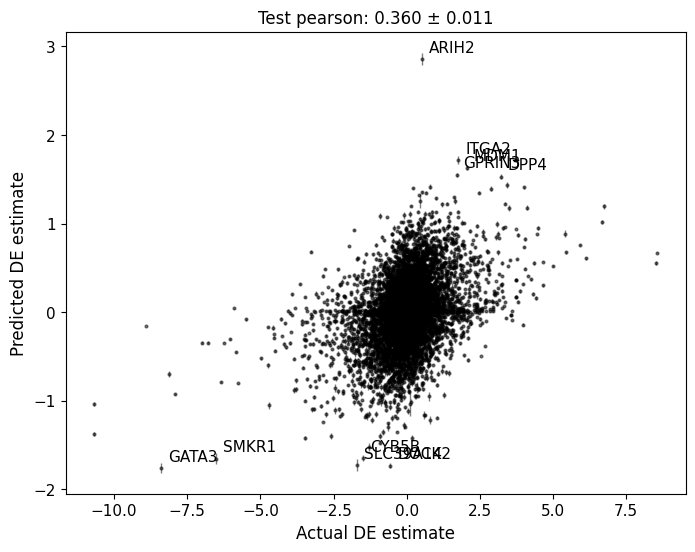

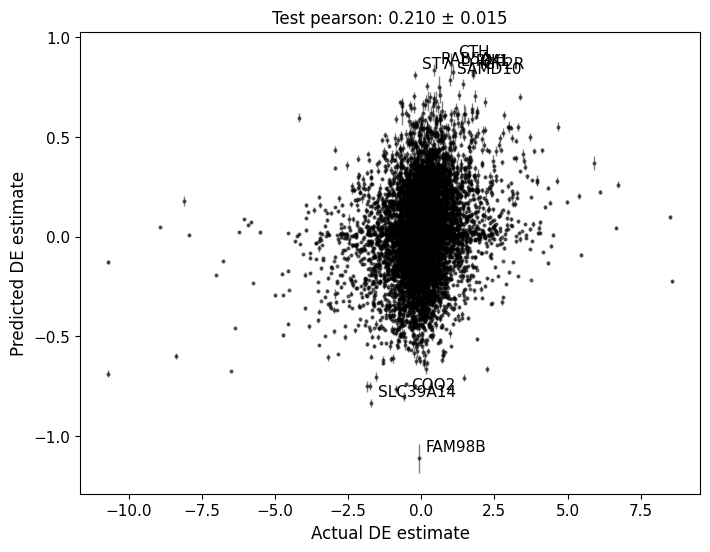

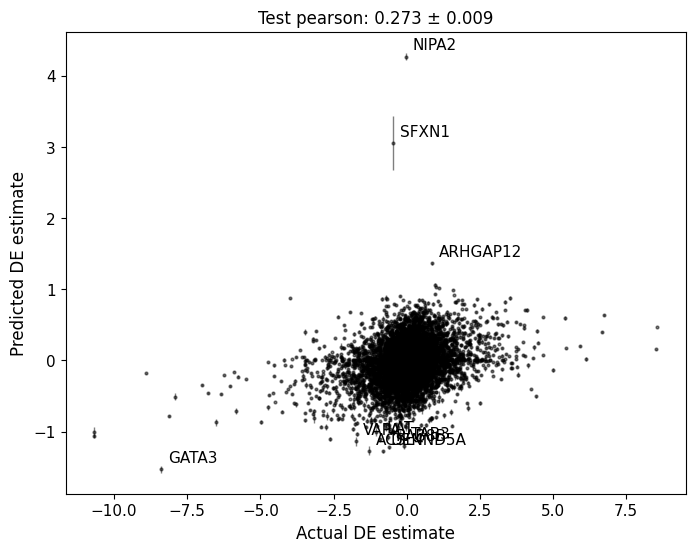

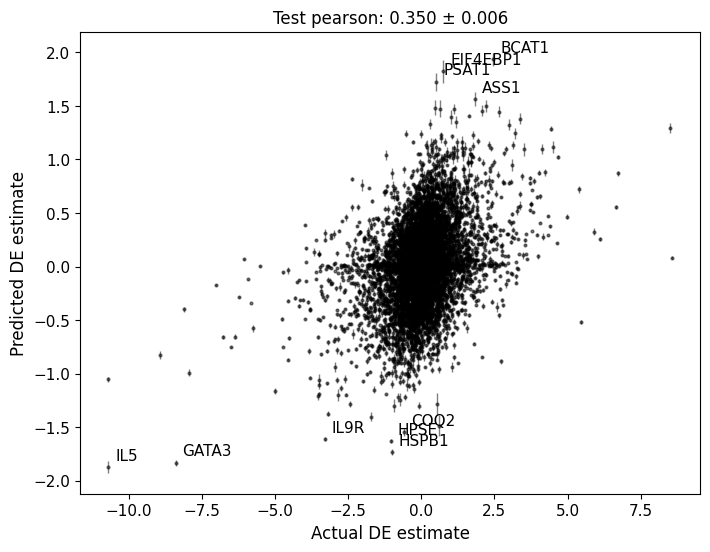

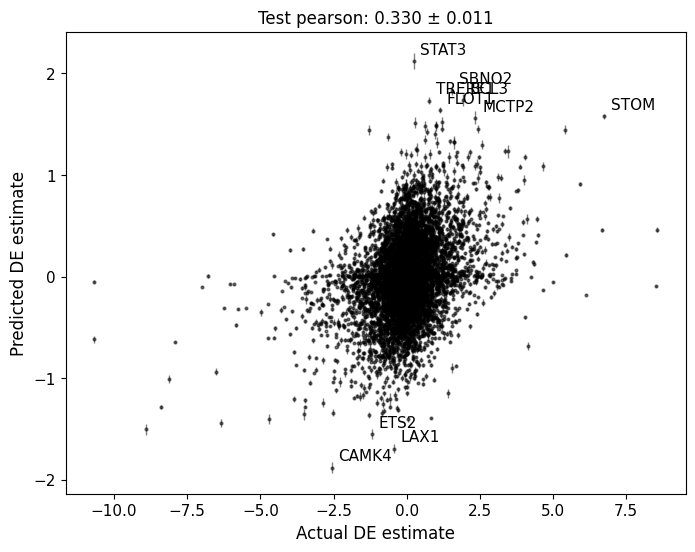

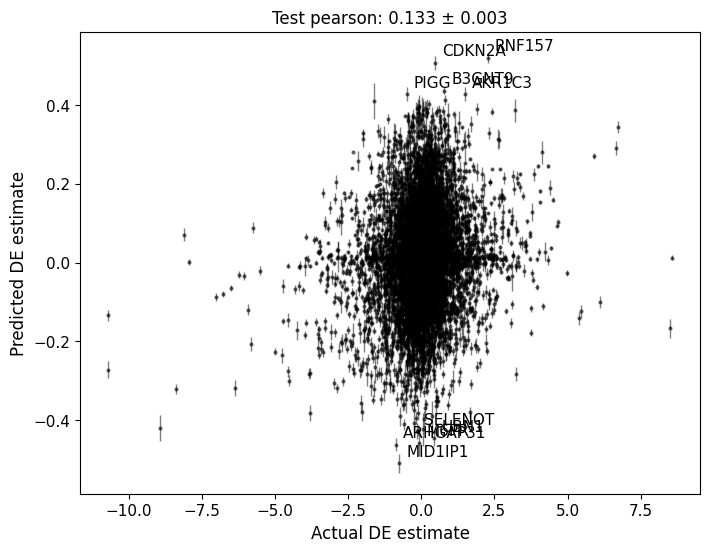

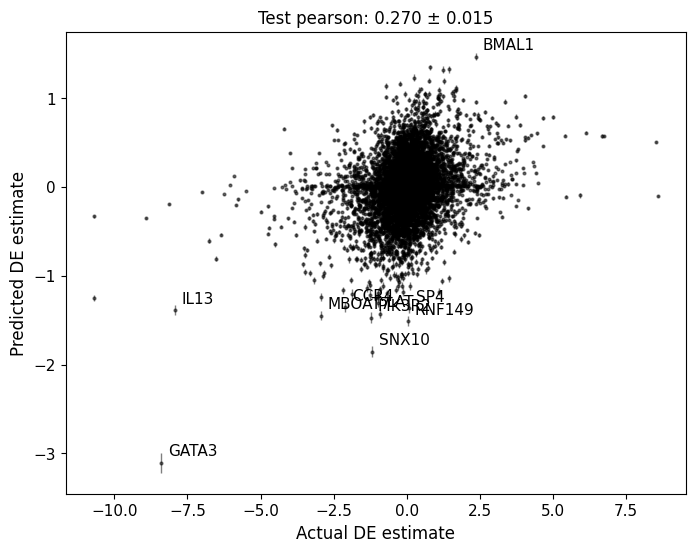

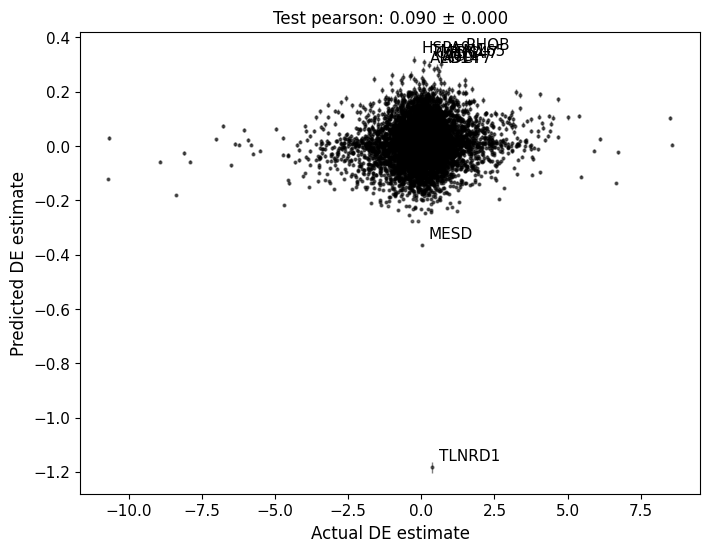

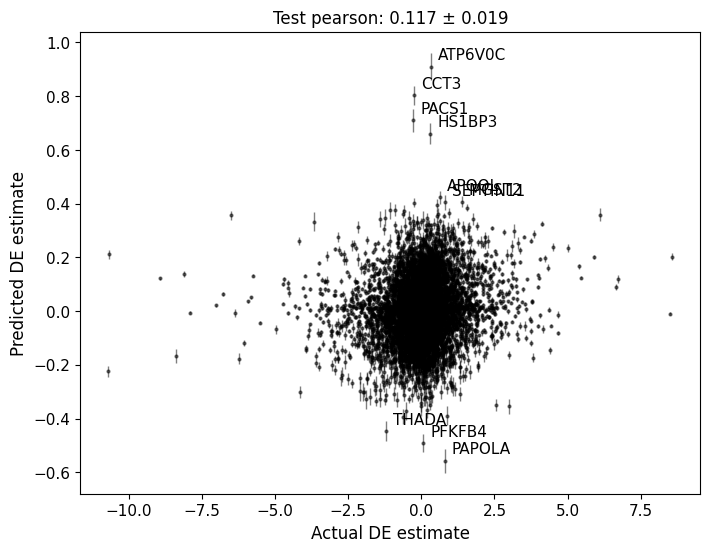

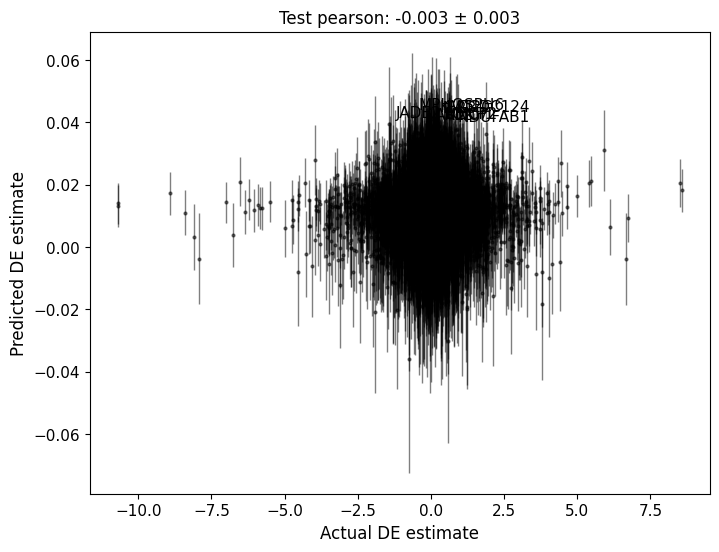

In [193]:
st = 'Th1'
p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()

# Initialize a list to store results for each cluster
cluster_results = []

# Iterate through clusters 1 and 2
for cluster_num in row_cluster_df['cluster'].unique():
    subset_regs = row_cluster_df.groupby('cluster')['regulator'].apply(list)[cluster_num]
    print(f"Cluster {cluster_num} regulators:", subset_regs)
    
    # Fit model and get predictions
    p2t_model = Perturb2TissueModel(pca_transform=False, n_pcs=10, n_splits=3, n_repeats=1, positive=False)
    p2t_model.fit(X_perturbs[subset_regs], y_target[X_perturbs.index], model_id=f'subset_cluster_{cluster_num}')
    
    # Plot predictions 
    pl = p2t_model.plot_prediction(X_perturbs[subset_regs], y_target, annotate_top_n=10, plot_metric='pearson')
    
    # Get predictions
    preds = p2t_model.get_prediction(X_perturbs[subset_regs])
    preds['true'] = y_target
    
    # Calculate metrics
    shrink_adjusted_error = p2t_model.get_genelevel_error(X_perturbs[subset_regs], y_target[X_perturbs.index])
    
    # Add cluster number to results
    preds['cluster'] = cluster_num
    preds['shrink_adjusted_error'] = shrink_adjusted_error
    
    # Store results
    cluster_results.append(preds)

# Combine results into a single DataFrame
combined_results = pd.concat(cluster_results)


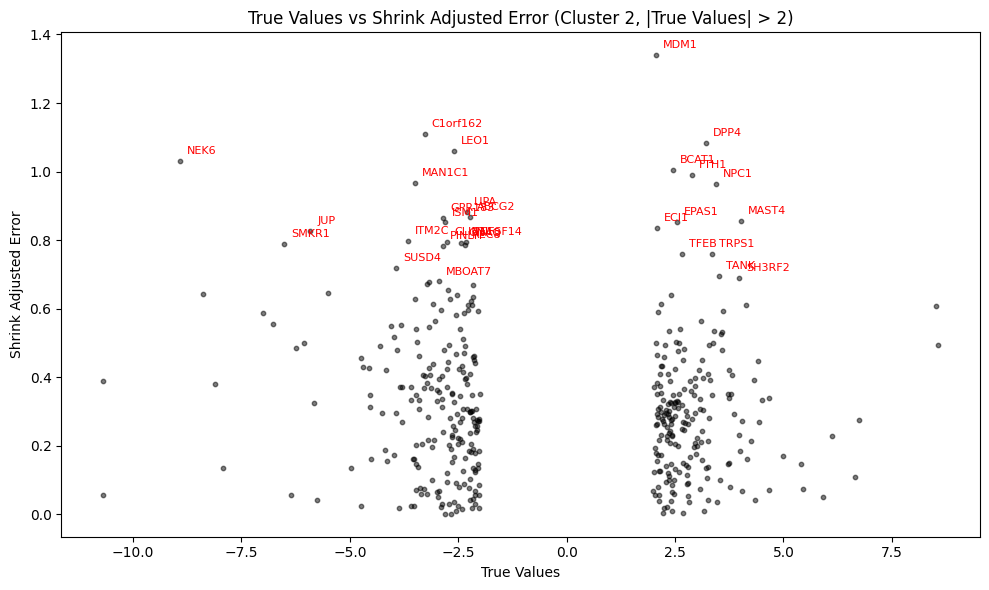

In [178]:
# Plot true values vs shrink adjusted error for cluster 2, annotating genes with highest error
cluster_2_results = combined_results[combined_results['cluster'] == 2]

# Filter to Th signature genes (true zscore > 2)
filtered_cluster_2_results = cluster_2_results[abs(cluster_2_results['true']) > 2]

plt.figure(figsize=(10, 6))
plt.scatter(filtered_cluster_2_results['true'], filtered_cluster_2_results['shrink_adjusted_error'], alpha=0.5, color='black', s=10)
plt.xlabel('True Values')
plt.ylabel('Shrink Adjusted Error')
plt.title('True Values vs Shrink Adjusted Error (Cluster 2, |True Values| > 2)')

# Find and annotate top 10 genes with highest error
top_error_genes = filtered_cluster_2_results.nlargest(30, 'shrink_adjusted_error')
for idx, row in top_error_genes.iterrows():
    plt.annotate(idx, 
                 (row['true'], row['shrink_adjusted_error']), 
                 xytext=(5, 5), 
                 textcoords='offset points', 
                 fontsize=8,
                 color='red')

plt.tight_layout()

Compare predictions from 2 subsets of regulators

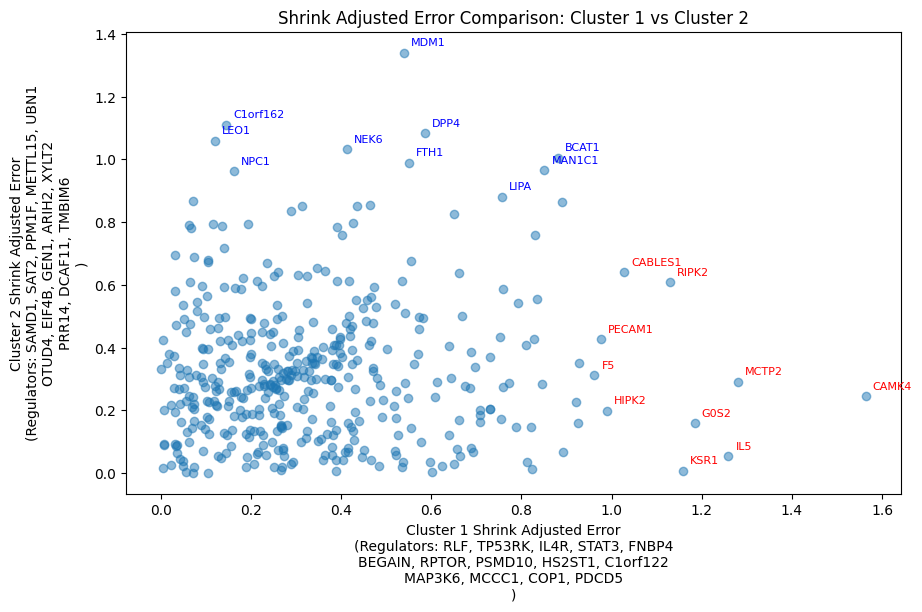

In [189]:

# Get shrink adjusted error for clusters 1 and 2, filtering to Th signature genes
cluster_1_error = combined_results[(combined_results['cluster'] == 1) & (abs(combined_results['true']) > 2)]['shrink_adjusted_error']
cluster_2_error = combined_results[(combined_results['cluster'] == 2) & (abs(combined_results['true']) > 2)]['shrink_adjusted_error']

cl1_regs = row_cluster_df.groupby('cluster')['regulator'].apply(list)[1]
cl2_regs = row_cluster_df.groupby('cluster')['regulator'].apply(list)[2]

# Create a DataFrame to plot
error_comparison = pd.DataFrame({
    'Cluster 1 Error': cluster_1_error,
    'Cluster 2 Error': cluster_2_error
})

# Plot with annotations of top genes
plt.figure(figsize=(10, 6))
plt.scatter(error_comparison['Cluster 1 Error'], error_comparison['Cluster 2 Error'], alpha=0.5)
plt.xlabel(f'Cluster 1 Shrink Adjusted Error\n(Regulators: {", ".join(cl1_regs[:5])}\n{", ".join(cl1_regs[5:10])}\n{", ".join(cl1_regs[10:15])}\n{", ".join(cl1_regs[15:])})')
plt.ylabel(f'Cluster 2 Shrink Adjusted Error\n(Regulators: {", ".join(cl2_regs[:5])}\n{", ".join(cl2_regs[5:10])}\n{", ".join(cl2_regs[10:15])}\n{", ".join(cl2_regs[15:])})')
plt.title('Shrink Adjusted Error Comparison: Cluster 1 vs Cluster 2')

# Find top genes for both clusters
top_cluster_1 = combined_results[(combined_results['cluster'] == 1) & (abs(combined_results['true']) > 2)].nlargest(10, 'shrink_adjusted_error')
top_cluster_2 = combined_results[(combined_results['cluster'] == 2) & (abs(combined_results['true']) > 2)].nlargest(10, 'shrink_adjusted_error')

# Annotate top genes
for idx, row in top_cluster_1.iterrows():
    cluster_1_error_val = row['shrink_adjusted_error']
    cluster_2_error_val = cluster_2_error.loc[idx] if idx in combined_results.index else None
    plt.annotate(idx, 
                     (cluster_1_error_val, cluster_2_error_val), 
                     xytext=(5, 5), 
                     textcoords='offset points', 
                     fontsize=8,
                     color='red')

for idx, row in top_cluster_2.iterrows():
    cluster_2_error_val = row['shrink_adjusted_error']
    cluster_1_error_val = cluster_1_error.loc[idx] if idx in combined_results.index else None
    # if cluster_1_error_val is not None:
    plt.annotate(idx, 
                    (cluster_1_error_val, cluster_2_error_val), 
                    xytext=(5, 5), 
                    textcoords='offset points', 
                    fontsize=8,
                    color='blue')

# plt.tight_layout()


---

In [170]:
st = 'Treg'
p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
    


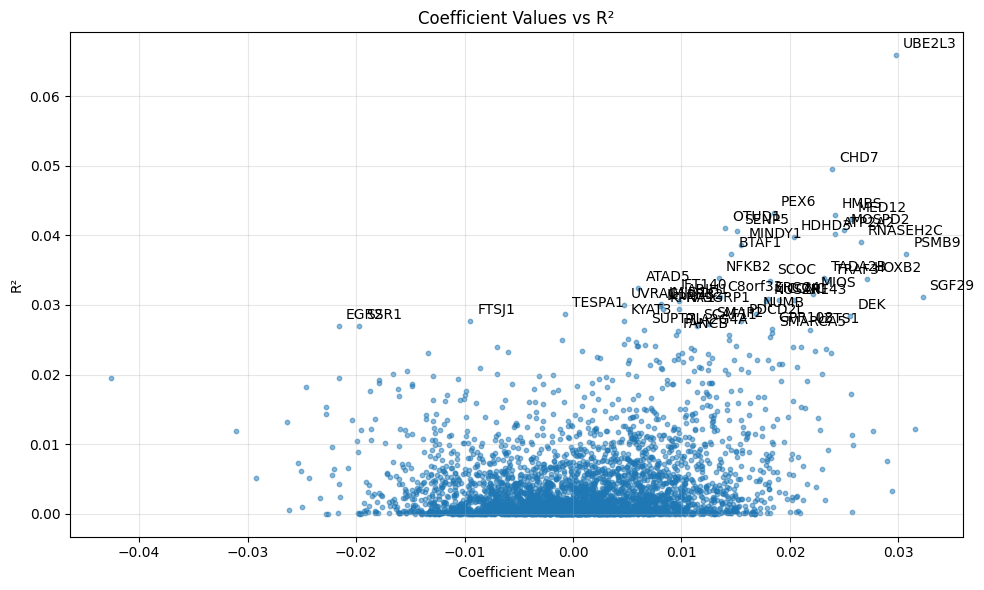

In [171]:
coefs_df = p2t_model.get_coefs()
r2_df = p2t_model.get_r2(X_perturbs, y_target)
pt_coefs = pd.concat([coefs_df, r2_df], axis=1).astype('float')
# Create scatter plot of coefficients vs r2
plt.figure(figsize=(10, 6))
plt.scatter(pt_coefs['coef_mean'], pt_coefs['r2'], alpha=0.5, s=10)

# Get top 10 genes by absolute coefficient value
top_coefs = pt_coefs['r2'].nlargest(50).index

# Add annotations for top coefficient genes
for gene in top_coefs:
    plt.annotate(gene, 
                (pt_coefs.loc[gene, 'coef_mean'], pt_coefs.loc[gene, 'r2']),
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('Coefficient Mean')
plt.ylabel('R²')
plt.title('Coefficient Values vs R²')
plt.grid(True, alpha=0.3)
plt.tight_layout()


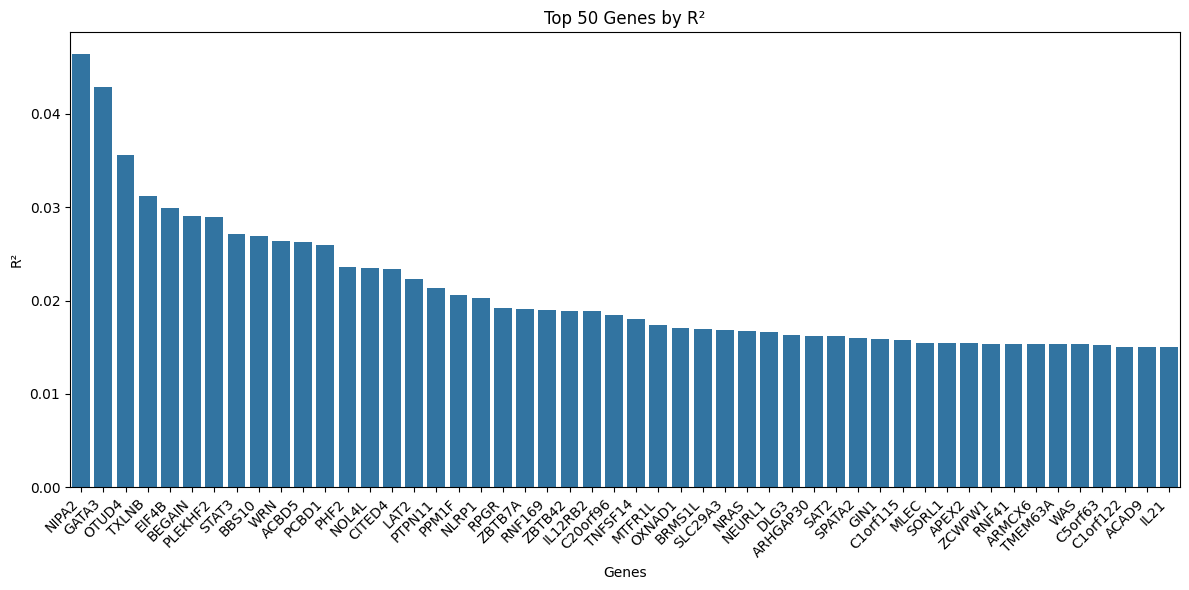

In [150]:
plt.figure(figsize=(12, 6))
sns.barplot(x=r2_top.index.tolist(), y=r2_top['r2'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genes')
plt.ylabel('R²')
plt.title('Top 50 Genes by R²')
plt.tight_layout()

In [132]:

g = 'GATA3'
st = 'Th1'

p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
pt_coefs = p2t_model.get_coefs()

# Initialize empty dataframe to store r2 values
r2_df = pd.DataFrame(index=X_perturbs.columns, columns=['r2'])

# Calculate r2 for each column
for col in X_perturbs.columns:
    # Get perturbation effects for this gene
    X_g = X_perturbs[col]
    # Mask self-perturbation and fill with mean
    X_g = X_g.mask(X_g.index == col).fillna(X_g.mean())
    # Calculate predictions using coefficients
    pred_from_g = X_g * pt_coefs['coef_mean'].loc[col]
    # Calculate correlation and r2
    corr, _ = scipy.stats.pearsonr(pred_from_g, y_target)
    r2_df.loc[col, 'r2'] = corr**2

# Sort by r2 values
r2_df = r2_df.sort_values('r2', ascending=False)
r2_df

r2
target_contrast_gene_name          
NIPA2                      0.046418
GATA3                      0.042888
OTUD4                      0.035552
TXLNB                      0.031241
EIF4B                      0.029963
...                             ...
GDF9                            0.0
AHCYL1                          0.0
CNOT6L                          0.0
IQCC                            0.0
ARF1                            0.0

[3861 rows x 1 columns]

<Axes: xlabel='coef_mean', ylabel='r2'>

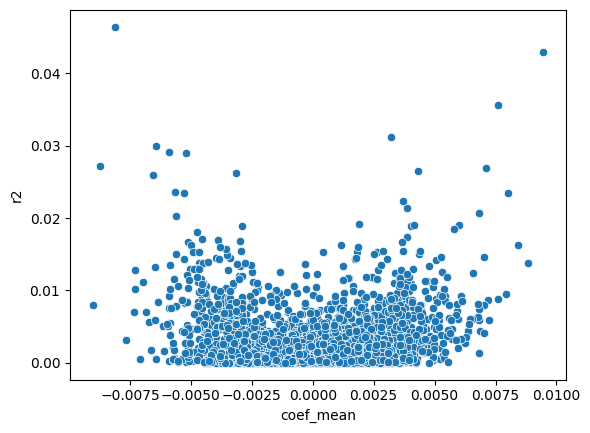

In [ ]:
pt_coefs['r2'] = r2_df['r2']
sns.scatterplot(data=pt_coefs, x='coef_mean', y='r2')

In [139]:
pt_coefs.sort_values('r2', ascending=False)[0:40]

coef_mean  coef_sem        r2
NIPA2     -0.008121  0.000211  0.046418
GATA3      0.009467  0.000254  0.042888
OTUD4      0.007609  0.000096  0.035552
TXLNB      0.003214  0.000244  0.031241
EIF4B     -0.006426  0.000105  0.029963
BEGAIN    -0.005919  0.000239  0.029107
PLEKHF2   -0.005194  0.000255  0.028973
STAT3     -0.008712  0.000355  0.027131
BBS10      0.007118  0.000190  0.026897
WRN        0.004310  0.000237  0.026432
ACBD5     -0.003156  0.000218  0.026247
PCBD1     -0.006560  0.000235  0.025934
PHF2      -0.005640  0.000139   0.02365
NOL4L      0.008025  0.000598  0.023486
CITED4    -0.005288  0.000129  0.023396
LAT2       0.003685  0.000347  0.022288
PTPN11     0.003877  0.000293  0.021394
PPM1F      0.006842  0.000262  0.020645
NLRP1     -0.005625  0.000343  0.020324
RPGR       0.001877  0.000137  0.019173
ZBTB7A     0.004173  0.000062  0.019091
RNF169     0.005991  0.000149  0.019047
ZBTB42    -0.002919  0.000256  0.018915
IL12RB2    0.004046  0.000177  0.018857
C20orf96   0.005813  0.000245  0.018496
TNFSF14   -0.004759  0.000040   0.01805
MTFR1L     0.003853  0.000133  0.017373
OXNAD1    -0.004527  0.000256  0.017117
BRMS1L    -0.003904  0.000166  0.017009
SLC29A3   -0.003002  0.000279  0.016885
NRAS       0.003669  0.000405  0.016737
NEURL1    -0.005107  0.000283   0.01666
DLG3       0.001173  0.000282  0.016294
ARHGAP30  -0.004986  0.000245  0.016259
SAT2       0.008425  0.000105  0.016226
SPATA2     0.001873  0.000182  0.015965
GIN1      -0.003789  0.000174  0.015928
C1orf115  -0.003541  0.000092  0.015733
MLEC      -0.002960  0.000343  0.015472
SORL1      0.004396  0.000166  0.015468

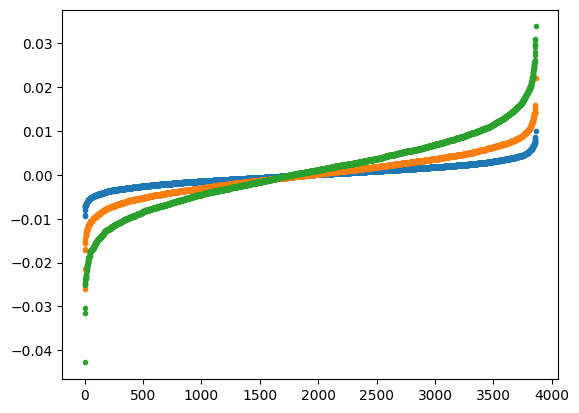

In [408]:
plt.plot(coefs_wide['Th1'].sort_values().values, '.')
plt.plot(coefs_wide['Th2'].sort_values().values, '.')
plt.plot(coefs_wide['Treg'].sort_values().values, '.')

In [251]:
# Normalize each row to sum to 1
coefs_wide_norm = coefs_wide.apply(lambda x: x - x.min(), axis=1)
# Get top 20 absolute values for each column and save in a list
top_genes_list = []
for col in coefs_wide_norm.columns:
    # Get absolute values and sort
    abs_values = coefs_wide_norm[col].abs().sort_values(ascending=False)
    # Get top 20 gene names and values
    top_20 = [gene for gene in abs_values.head(50).index]
    top_genes_list.extend(top_20)

top_genes_list = list(set(top_genes_list))


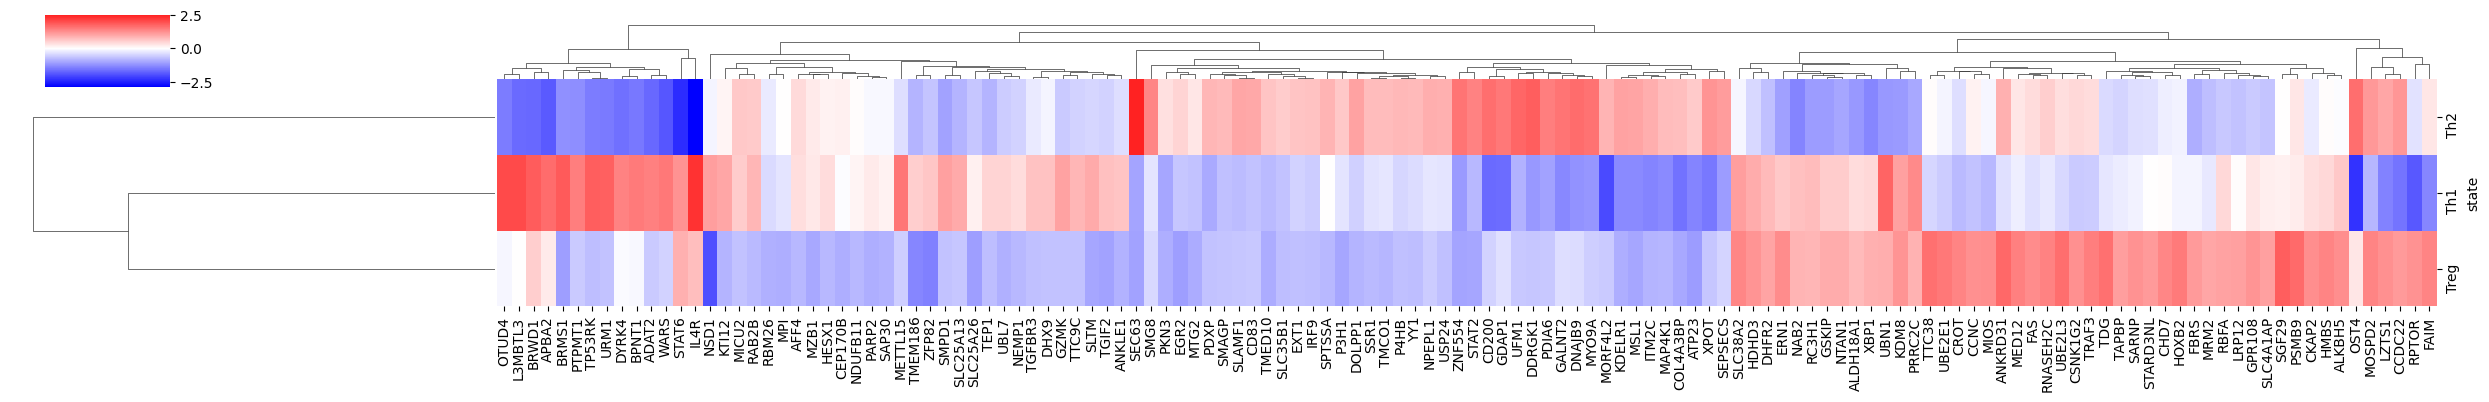

In [259]:
sns.clustermap(coefs_wide.loc[top_genes_list].T, center=0, cmap='bwr', figsize=(25,4), xticklabels=True, z_score=False)

Text(0.5, 1.0, 'Effect of Low Regulators on Most Affected Genes')

<Figure size 1500x2000 with 0 Axes>

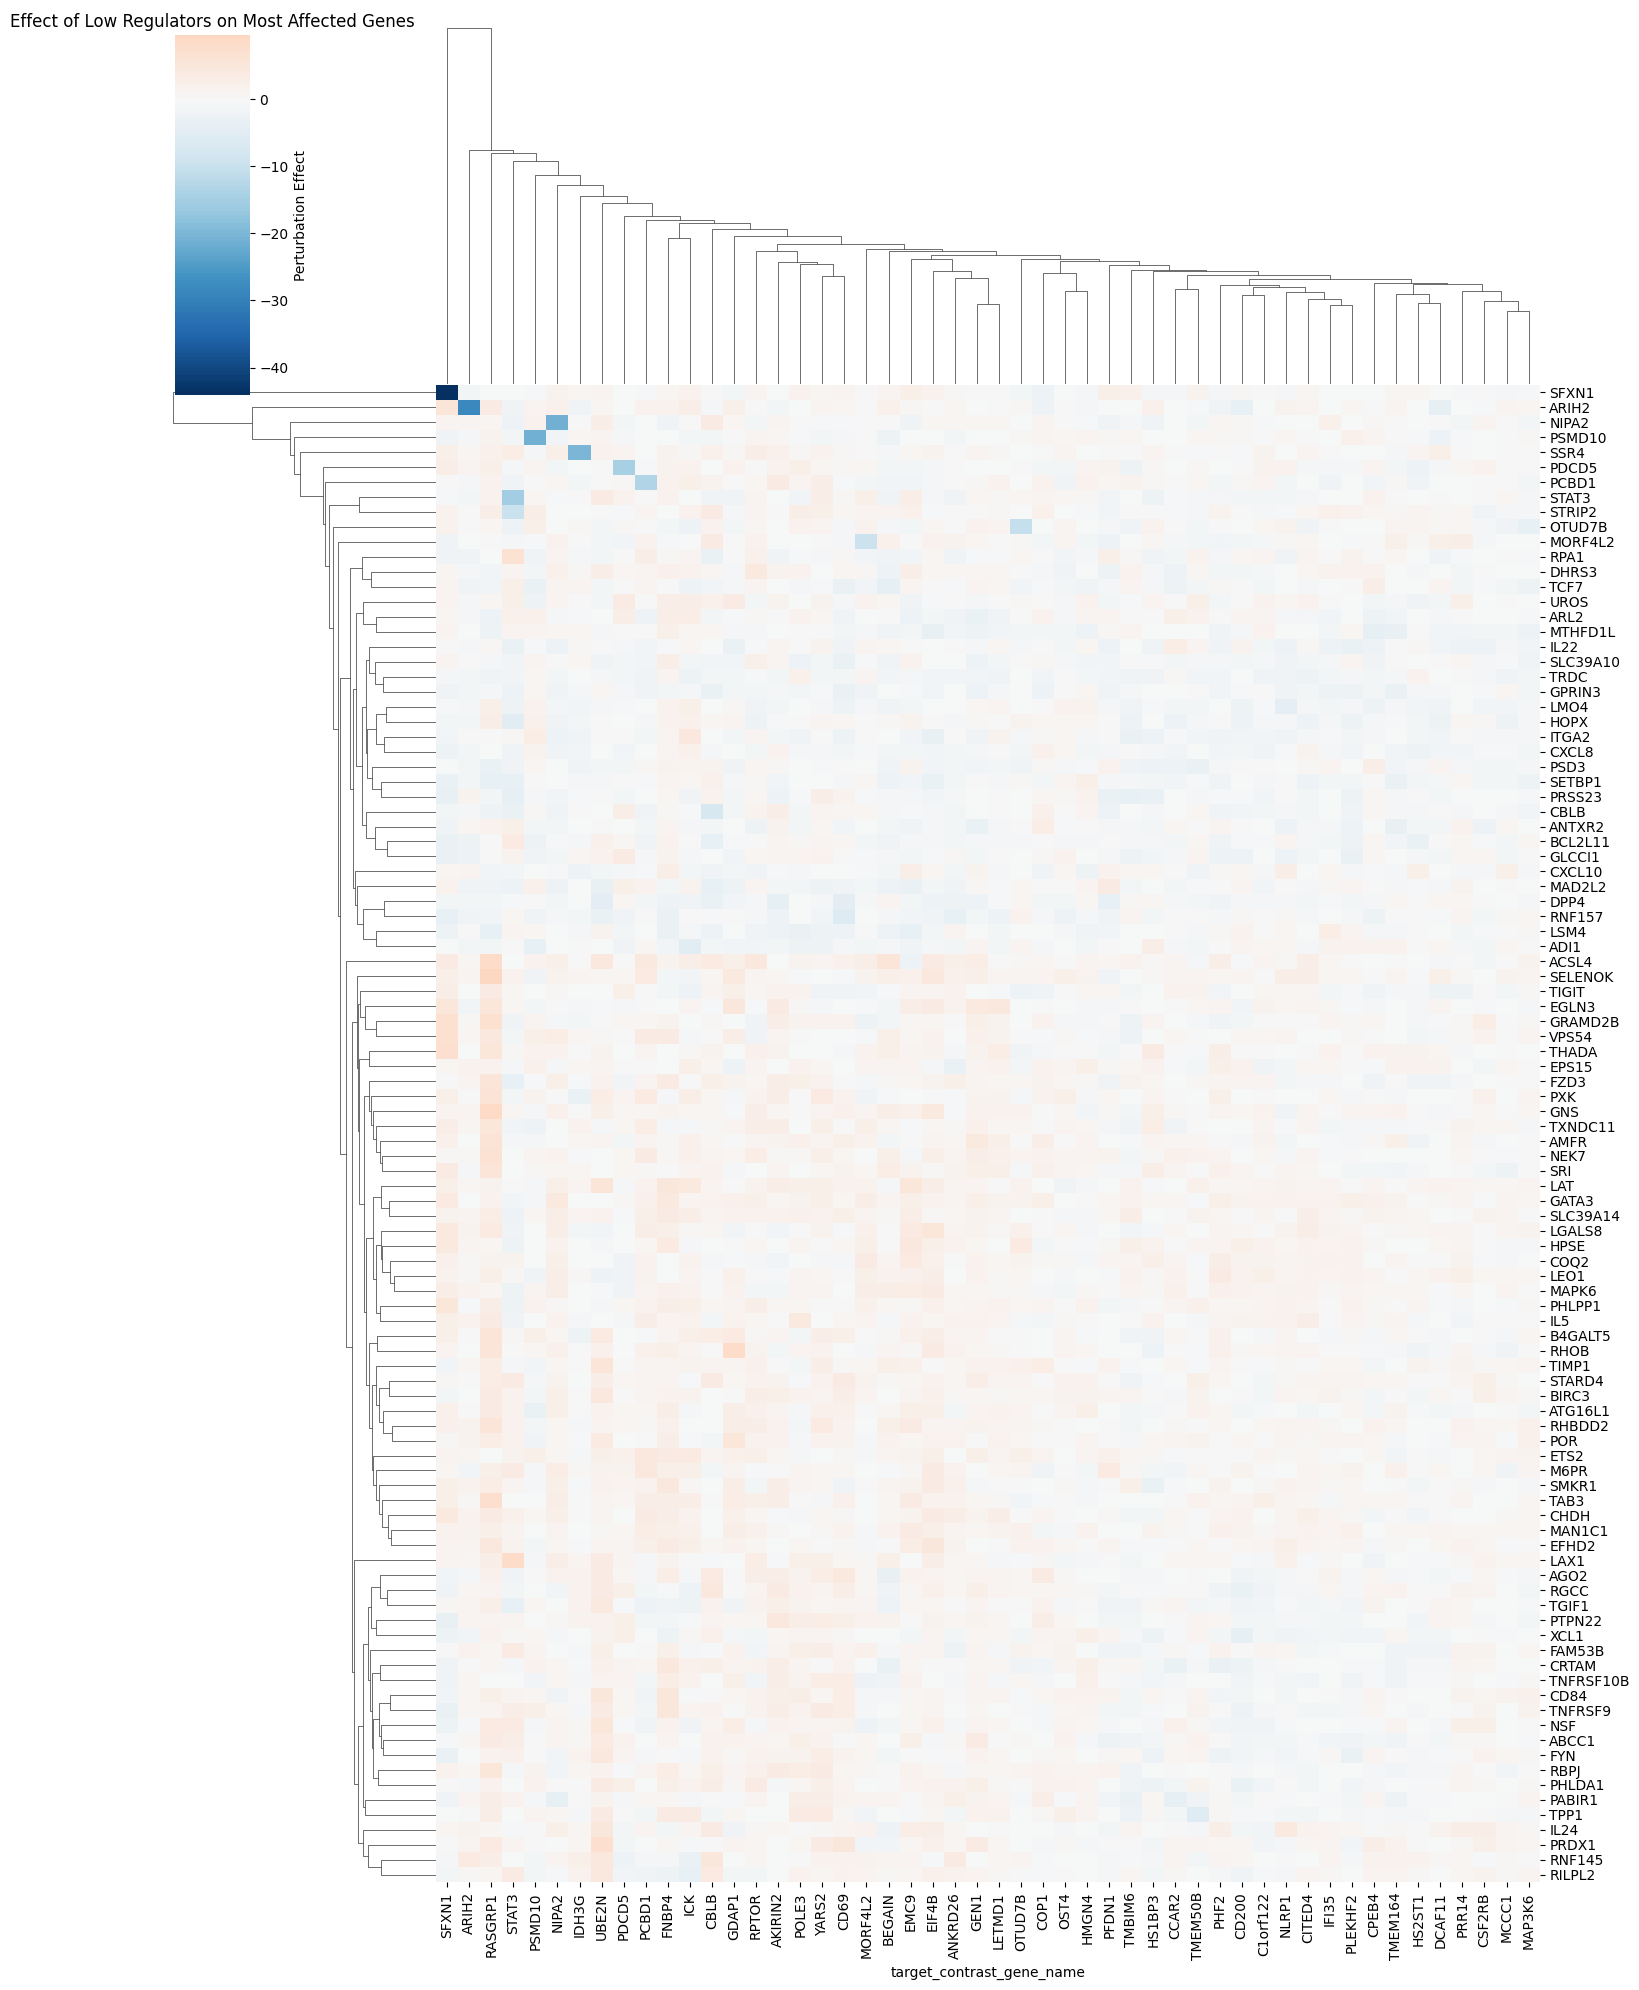

In [38]:
low_regs = coefs_wide['Th1'].sort_values()[0:50].index.tolist()
# Get the perturbation effects for low_regs
perturb_effects = X_perturbs[low_regs]

# Get the 200 genes most affected by these perturbations
# Calculate mean absolute effect across perturbations
mean_effects = perturb_effects.abs().mean(axis=1)
top_affected_genes = mean_effects.nlargest(100).index

# Create clustered heatmap
plt.figure(figsize=(15, 20))
sns.clustermap(perturb_effects.loc[top_affected_genes], 
               center=0,
               cmap='RdBu_r',
               xticklabels=True,
               yticklabels=True,
               figsize=(15, 20),
               cbar_kws={'label': 'Perturbation Effect'})
plt.title('Effect of Low Regulators on Most Affected Genes')

In [759]:
st='Th1'
p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
mod_ix = 
comps = pd.DataFrame(p2t_model.pcas[mod_ix].components_, columns=X_perturbs.columns)
top = p2t_model.models[mod_ix].coef_.argmax()
# plt.plot(top, '.')
comps.iloc[top,:].sort_values()

target_contrast_gene_name
GIN1      -0.059474
HELZ      -0.058324
DNTTIP1   -0.055660
CCDC6     -0.055113
AP3M1     -0.053719
             ...   
PHF12      0.049750
SMARCB1    0.050056
ZBTB48     0.050656
SIN3B      0.054089
NSD1       0.091510
Name: 29, Length: 3861, dtype: float64

In [ ]:
st = 'Treg'
p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()

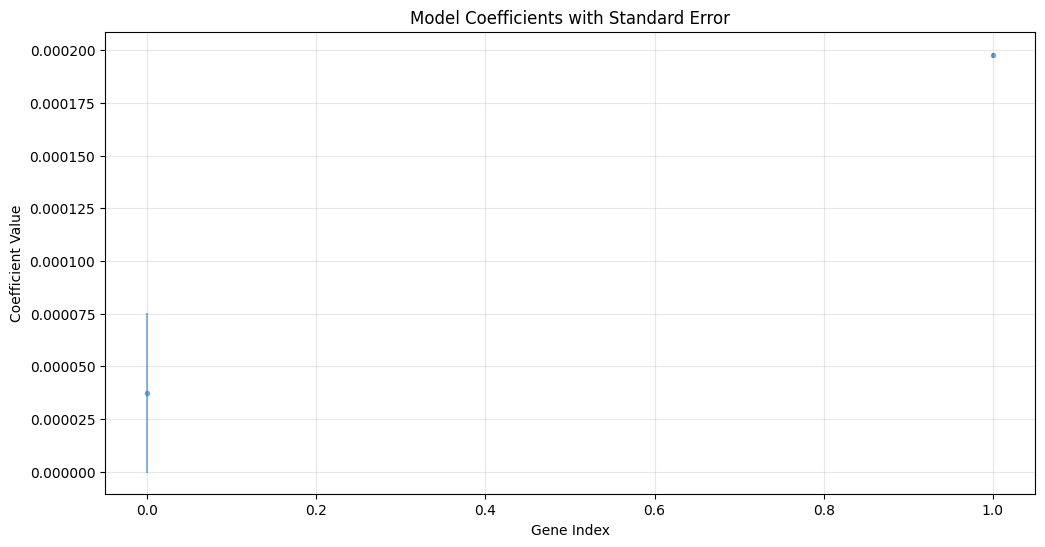

coef_mean  coef_sem
coef_mean   0.000037  0.000038
coef_sem    0.000198  0.000001

In [761]:
coefs = p2t_model.get_coefs()
coefs_mean = coefs.mean(axis=0)
coefs_sem = coefs.sem(axis=0)

# Create DataFrame with mean and SEM
coefs_df = pd.DataFrame({
    'coef_mean': coefs_mean,
    'coef_sem': coefs_sem
})

# Plot mean coefficients with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(range(len(coefs_mean)), coefs_mean, yerr=coefs_sem, fmt='.', alpha=0.5)
plt.title('Model Coefficients with Standard Error')
plt.xlabel('Gene Index')
plt.ylabel('Coefficient Value')
plt.grid(True, alpha=0.3)
plt.show()

coefs_df

In [452]:
import decoupler as dc

In [594]:
msigdb_table = decoupler.op.resource('MSigDB')

In [645]:
msigdb_table.collection.value_counts()

collection
immunesigdb                           1211234
go_biological_process                 1028339
human_phenotype_ontology               643992
chemical_and_genetic_perturbations     520915
mirna_targets_mirdb                    468097
tf_targets_gtrf                        278854
reactome_pathways                      207025
tf_targets_legacy                      199207
cell_type_signatures                   193040
go_cellular_component                  177903
go_molecular_function                  176652
cancer_modules                          68839
wikipathways                            59269
vaccine_response                        58531
cancer_gene_neighborhoods               57559
mirna_targets_legacy                    44535
oncogenic_signatures                    39253
kegg_pathways                           27028
positional                              24437
pid_pathways                            16547
hallmark                                11319
biocarta_pathways      

In [669]:
ctsig_table = msigdb_table[msigdb_table.collection == 'kegg_pathways']
immunesig_db_table = msigdb_table[msigdb_table['collection'] == 'immunesigdb']

In [681]:
[x for x in ctsig_table.geneset if 'T_CELL' in x]

['KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CE

In [670]:
net = ctsig_table.rename({'geneset':'source', 'genesymbol':'target'}, axis=1)
net = net.drop_duplicates(subset=['source', 'target'])

In [671]:
input_df = coefs_wide[['Th1']].T
input_df.index.name = None

In [695]:
scores  = decoupler.mt.decouple(coefs_wide[['Th2']].T.abs(), net=net)


AttributeError: 'NoneType' object has no attribute '__name__'

In [689]:
scores.T

Th2
KEGG_ACUTE_MYELOID_LEUKEMIA                      1.319735
KEGG_ADHERENS_JUNCTION                           1.030324
KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY             1.289013
KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM  1.138446
KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION   0.780028
...                                                   ...
KEGG_VASOPRESSIN_REGULATED_WATER_REABSORPTION    0.702157
KEGG_VEGF_SIGNALING_PATHWAY                      1.202326
KEGG_VIBRIO_CHOLERAE_INFECTION                   1.225944
KEGG_VIRAL_MYOCARDITIS                           0.920714
KEGG_WNT_SIGNALING_PATHWAY                       1.233907

[154 rows x 1 columns]

In [691]:
pvals.T.sort_values('Th2')

Th2
KEGG_JAK_STAT_SIGNALING_PATHWAY               0.308000
KEGG_CHRONIC_MYELOID_LEUKEMIA                 0.435803
KEGG_CYSTEINE_AND_METHIONINE_METABOLISM       0.435803
KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION   0.435803
KEGG_DNA_REPLICATION                          0.435803
...                                                ...
KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS  0.994032
KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM          0.994032
KEGG_REGULATION_OF_ACTIN_CYTOSKELETON         0.994032
KEGG_CELL_ADHESION_MOLECULES_CAMS             0.994032
KEGG_GLYCOLYSIS_GLUCONEOGENESIS               0.995885

[154 rows x 1 columns]

(None,
 array(['IL4R', 'STAT6', 'STAT2', 'CSF2RB', 'CREBBP', 'EP300', 'AKT3',
        'STAT1', 'STAT3', 'CBLB', 'IL10RA', 'IFNGR2', 'AKT1', 'PTPN11',
        'IRF9', 'STAT5A', 'IFNAR1', 'IL4', 'PIK3CB', 'GRB2', 'CCND2',
        'PIK3CA', 'IL12RB2', 'AKT2', 'PIK3CG'], dtype='<U10'))

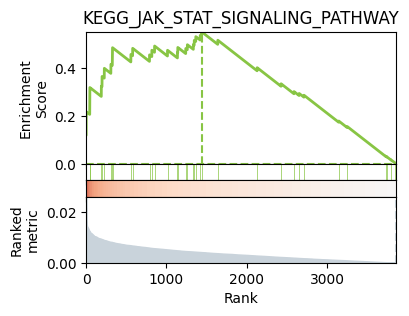

In [693]:
decoupler.pl.leading_edge(coefs_wide.abs(), net=net, stat='Th2', name='KEGG_JAK_STAT_SIGNALING_PATHWAY')

In [562]:
tf_acts

Androgen      EGFR  Estrogen   Hypoxia  JAK-STAT      MAPK      NFkB  \
Treg  0.858993  1.032567  0.904279  1.045801  1.044117  1.086472  1.102279   

          PI3K      TGFb     TNFa     Trail      VEGF       WNT       p53  
Treg  0.977776  0.872948  1.08322 -1.208076  1.095913 -0.798849  0.963823

array([[<Axes: title={'center': 'Treg'}>]], dtype=object)

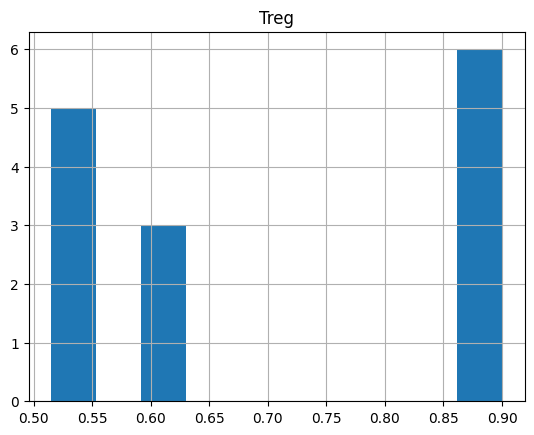

In [561]:
tf_padj.T.hist()

## Check single-cell states 

In [8]:
import glob
stim_sc_files = glob.glob(f'{datadir}/**/*Stim8hr*postQC.h5ad', recursive=True)
# Pick some lanes
stim_sc_files = stim_sc_files[0:10]

In [ ]:
import h5py
import anndata as ad
from tqdm import tqdm

adatas = []
all_highly_variable_genes = []
for f in tqdm(stim_sc_files):
    adata = ad.experimental.read_lazy(f)
    adata_ntc = adata[adata.obs['perturbed_gene_name'] == 'NTC'].copy()

    X_dask = adata_ntc.X
    X_dask = X_dask.map_blocks(lambda x: x.toarray(), dtype=X_dask.dtype, meta=np.array([]))
    col_sums = X_dask.sum(axis=0).compute()  # Compute sum along rows (axis=1)
    gene_mask = col_sums > 2

    adata_ntc = adata_ntc[:, gene_mask].copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    
    highly_variable_genes = set(adata.var_names[adata.var["highly_variable"]])
    all_highly_variable_genes.append(highly_variable_genes)
    adatas.append(adata)

In [45]:
from collections import Counter

## select the genes appears more than two lanes
gene_counts = Counter(gene for genes in all_highly_variable_genes for gene in genes)
selected_genes = {gene for gene, count in gene_counts.items() if count > 2}
print( len(selected_genes) )

for i,a in enumerate(adatas):
    common_genes = list(set(a.var_names) & selected_genes)
    a = a[:, common_genes].copy()
    a.obs = a.obs.to_dataframe()
    a.var = a.var.to_dataframe()
    output_path = f'{datadir}/tmp/Stim8hr_NTCs_preprocessed_s{i}.h5ad'
    a.write_h5ad(output_path)

1774


In [47]:
%%time
data_dict = {}
for i,_ in enumerate(adatas):
    data_dict.update({i:f'{datadir}/tmp/Stim8hr_NTCs_preprocessed_s{i}.h5ad'})

ad.experimental.concat_on_disk(
    data_dict,
    f'{datadir}/tmp/Stim8hr_NTCs_merged.h5ad',
    label='sample_id',
)

CPU times: user 3.22 s, sys: 2.65 s, total: 5.87 s
Wall time: 12.7 s


In [61]:
adata = sc.read_h5ad(f'{datadir}/tmp/Stim8hr_NTCs_merged.h5ad', backed=False)

In [63]:
sc.pp.pca(adata, n_comps=50)

In [86]:
adata.var = a.var[['gene_ids', 'gene_name']].loc[adata.var_names].copy()

In [87]:
adata.var_names = adata.var['gene_name'].values

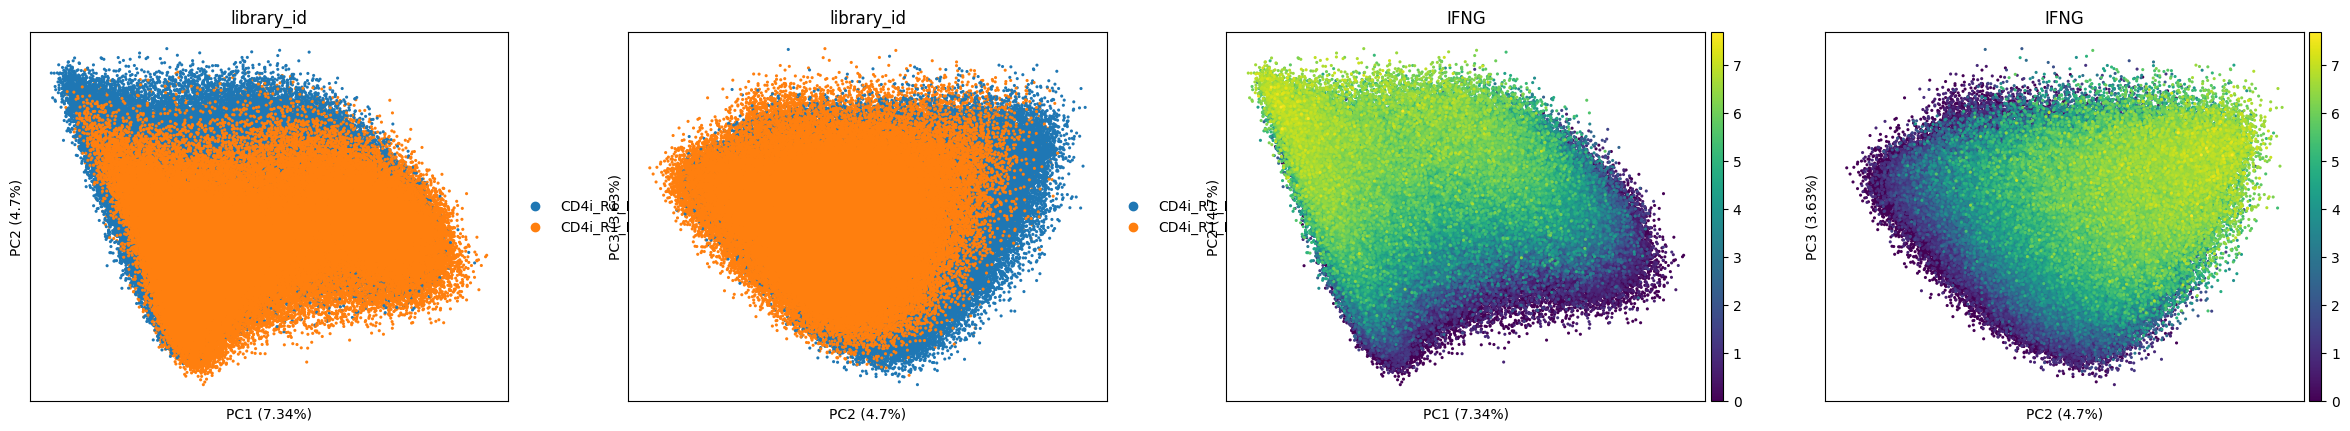

In [92]:
sc.pl.pca(adata, annotate_var_explained=True, color=['library_id', 'IFNG'], size=20, components=['1,2', '2,3'])

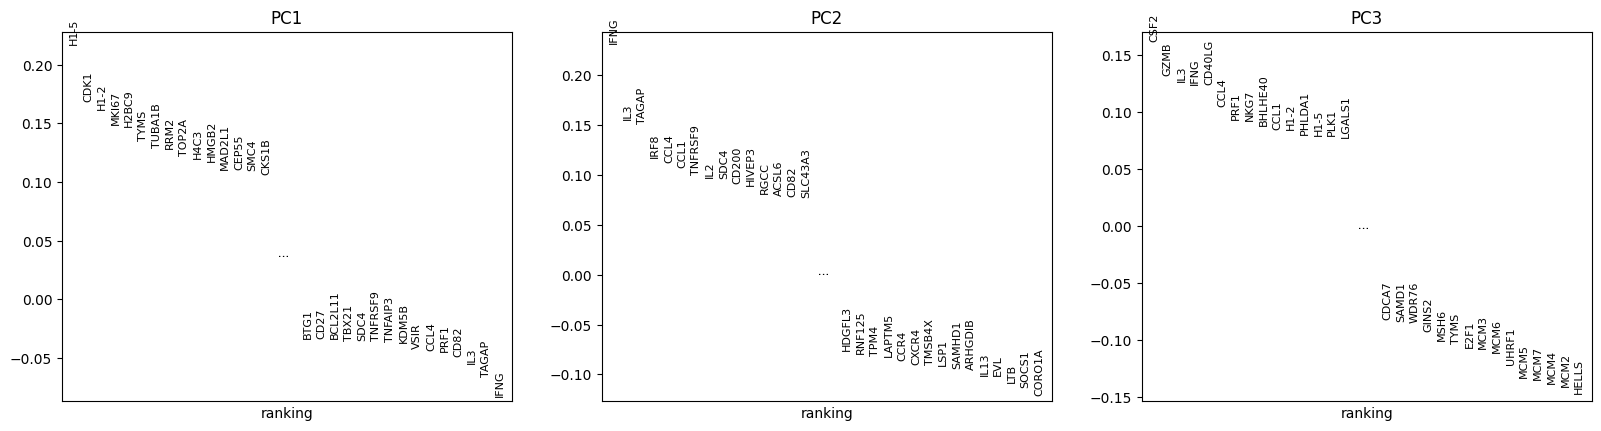

In [90]:
sc.pl.pca_loadings(adata)

In [327]:
target_hits = get_DE_results_long(adata_de, targets=['GATA3'])
target_hits = target_hits[target_hits['culture_condition'] == cond]
signif_genes = target_hits[target_hits['significant']]
signif_genes['class'] = np.where(np.sign(target_hits[target_hits['significant']].zscore) < 0, 'neg', 'pos')
signif_gene_classes = signif_genes.groupby('class')['gene'].apply(list).to_dict()
signif_gene_classes

/tmp/ipykernel_2698264/4045715312.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signif_genes['class'] = np.where(np.sign(target_hits[target_hits['significant']].zscore) < 0, 'neg', 'pos')


{'neg': ['ADAM19',
  'ANXA4',
  'ATP8B2',
  'CD44',
  'CLINT1',
  'CYLD',
  'EEIG1',
  'EML4',
  'ERN1',
  'GIMAP4',
  'GLUL',
  'ICAM2',
  'IFITM2',
  'IKZF1',
  'IL10RA',
  'IL32',
  'KLF2',
  'MORC2',
  'MYD88',
  'NME2',
  'NSA2',
  'PXN',
  'RASA3',
  'S100A10',
  'S100A11',
  'SAMD3',
  'SLFN5',
  'SOS1',
  'TNFSF10'],
 'pos': ['ADA',
  'CD3G',
  'CD7',
  'CD74',
  'CYFIP2',
  'FTH1',
  'GRK2',
  'HMGN1',
  'LBR',
  'MAL',
  'MAP4K4',
  'NHERF1',
  'RABL6',
  'SEPTIN6',
  'SNRPC',
  'STAU2',
  'YBX1']}

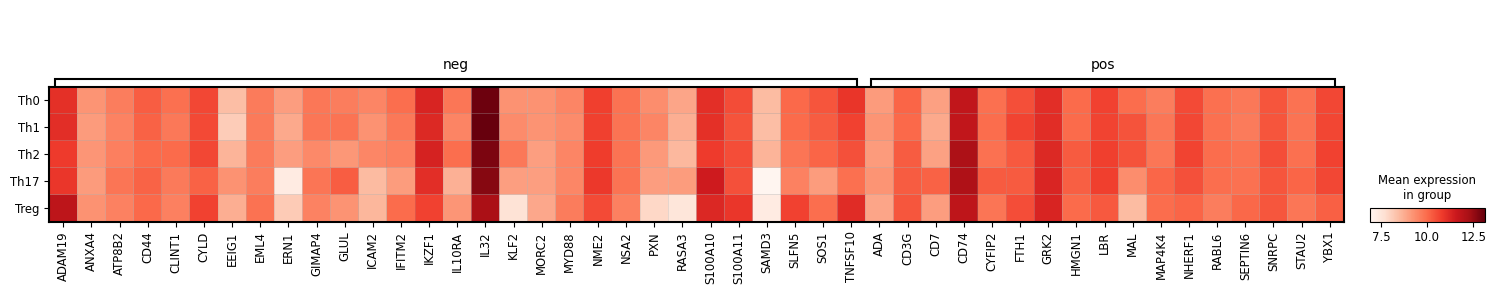

In [331]:
sc.pl.matrixplot(pbulk_adata[pbulk_adata.obs.culture_condition != 'Day0'], signif_gene_classes, groupby='culture_condition', cmap='Reds')

In [137]:
# Store evaluation results for different numbers of PCs
pc_eval_results = []

from tqdm.notebook import tqdm
for d in tqdm(np.linspace(10,100, 10), desc="Testing different PC counts"):
    p2t_model = Perturb2TissueModel(pca_transform=True, n_pcs=int(d), n_splits=3, n_repeats=3)
    p2t_model.fit(X_perturbs, y_target, model_id=f'Stim8hr_PC{int(d)}', frac_top_hvgs=0.50)
    
    # Get evaluation summary
    eval_summary = p2t_model.summarize_eval()
    eval_summary['n_pcs'] = int(d)
    
    # Store results
    pc_eval_results.append(eval_summary)


Testing different PC counts:   0%|          | 0/10 [00:00<?, ?it/s]

Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes


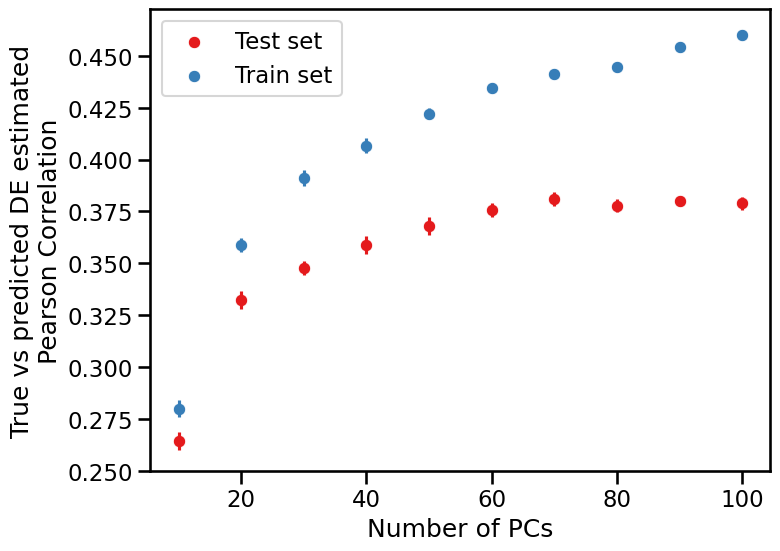

In [143]:
sns.set_context('talk')
# Combine all results into a single DataFrame
pc_eval_df = pd.concat(pc_eval_results)
# Create a figure with error bars showing standard error
fig, ax = plt.subplots(figsize=(8, 6))

# Use Set1 color palette
palette = sns.color_palette("Set1")

# Test pearson with matching color for points and error bars
sns.scatterplot(data=pc_eval_df, x='n_pcs', y='test_pearson', label='Test set', ax=ax, color=palette[0])
ax.errorbar(pc_eval_df['n_pcs'], pc_eval_df['test_pearson'], 
            yerr=pc_eval_df['test_pearson_se'], fmt='none', alpha=1, color=palette[0])

# Train pearson with matching color for points and error bars
sns.scatterplot(data=pc_eval_df, x='n_pcs', y='train_pearson', label='Train set', ax=ax, color=palette[1])
ax.errorbar(pc_eval_df['n_pcs'], pc_eval_df['train_pearson'], 
            yerr=pc_eval_df['train_pearson_se'], fmt='none', alpha=1, color=palette[1])

plt.xlabel('Number of PCs')
plt.ylabel('True vs predicted DE estimated\nPearson Correlation')
plt.legend()

### Simple correlation

Text(0.5, 1.0, 'Correlation: r = -0.164, p = 6.429e-43')

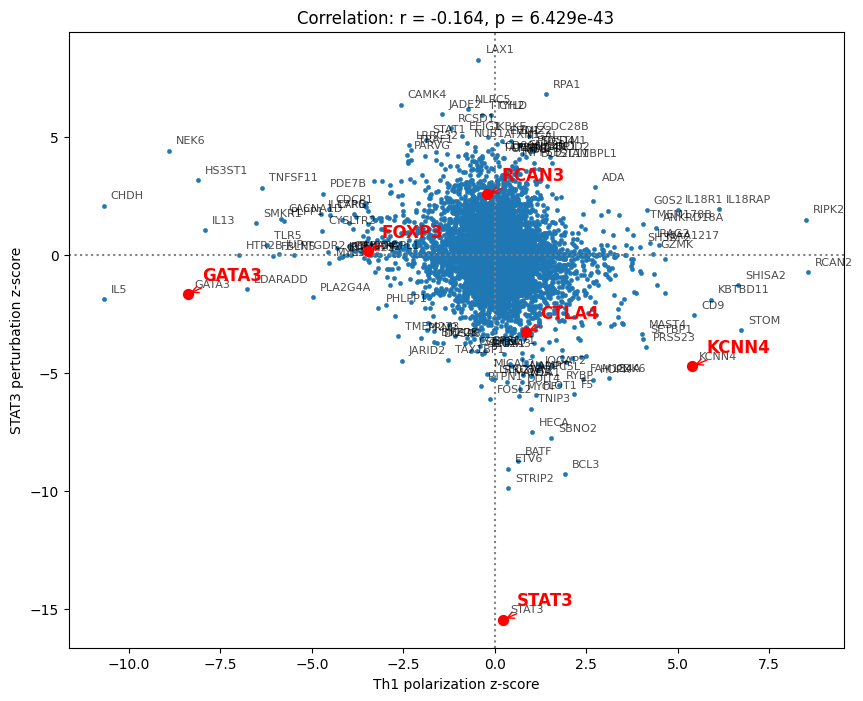

In [283]:
pseq_target = 'STAT3'
pol_condition = 'Th1'

perturbseq_results = get_DE_results_long(adata_de, targets=[pseq_target], effect_estimates=['zscore'])
perturbseq_results = perturbseq_results.set_index('gene_name')[['zscore', 'culture_condition']]
perturbseq_results = perturbseq_results[perturbseq_results['culture_condition'] == 'Stim8hr' ].copy()

polarization_results = all_results_df[all_results_df['contrast'] == pol_condition].set_index('variable')
polarization_results = polarization_results.rename({'zscore': 'zscore_polarization'}, axis=1)
compare_df = pd.concat([perturbseq_results, polarization_results], axis=1).dropna()

# Calculate correlation coefficient and p-value
from scipy import stats
corr, p_value = stats.pearsonr(compare_df['zscore_polarization'], compare_df['zscore'])

# Create scatter plot with correlation and p-value in title
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=compare_df, x='zscore_polarization', y='zscore', s=10, edgecolor=None, ax=ax)

# Add quadrant lines
plt.axhline(y=0, linestyle='dotted', color='gray')
plt.axvline(x=0, linestyle='dotted', color='gray')

# Annotate top genes in each quadrant
# Get top 5 genes by absolute distance from origin in each quadrant
for quadrant in ['top_right', 'top_left', 'bottom_right', 'bottom_left']:
    if quadrant == 'top_right':
        mask = (compare_df['zscore_polarization'] > 0) & (compare_df['zscore'] > 0)
    elif quadrant == 'top_left':
        mask = (compare_df['zscore_polarization'] < 0) & (compare_df['zscore'] > 0)
    elif quadrant == 'bottom_right':
        mask = (compare_df['zscore_polarization'] > 0) & (compare_df['zscore'] < 0)
    else:  # bottom_left
        mask = (compare_df['zscore_polarization'] < 0) & (compare_df['zscore'] < 0)
    
    quadrant_df = compare_df[mask].copy()
    if len(quadrant_df) > 0:
        # Calculate distance from origin
        quadrant_df['distance'] = np.sqrt(quadrant_df['zscore_polarization']**2 + quadrant_df['zscore']**2)
        # Get top 5 genes
        top_genes = quadrant_df.nlargest(30, 'distance')
        
        # Annotate points
        for idx, row in top_genes.iterrows():
            ax.annotate(idx, 
                       (row['zscore_polarization'], row['zscore']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.7)

# Highlight and annotate CTLA4 and FOXP3
highlight_genes = ['CTLA4', 'FOXP3', 'KCNN4', 'RCAN3', 'STAT3', 'GATA3']
for gene in highlight_genes:
    if gene in compare_df.index:
        row = compare_df.loc[gene]
        # Plot highlighted point
        ax.scatter(row['zscore_polarization'], row['zscore'], 
                  color='red', s=50, zorder=3)
        # Add annotation with arrow
        ax.annotate(gene,
                   (row['zscore_polarization'], row['zscore']),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=12, fontweight='bold',
                   color='red',
                   arrowprops=dict(arrowstyle='->', color='red'))

plt.xlabel(f'{pol_condition} polarization z-score')
plt.ylabel(f'{pseq_target} perturbation z-score')
plt.title(f'Correlation: r = {corr:.3f}, p = {p_value:.3e}')

In [236]:
pseq_target = 'GATA3'
perturbseq_results = get_DE_results_long(adata_de, targets=[pseq_target], effect_estimates=['zscore', 'log_fc'])
perturbseq_results[ perturbseq_results['significant'] ]

index     gene    zscore    log_fc  adj_p_value  \
45        ENSG00000107485_Rest    ABHD3  3.134213  0.280295     0.052651   
58        ENSG00000107485_Rest   ABRACL -2.918213 -0.187295     0.079782   
102       ENSG00000107485_Rest    ACOX3  3.547358  0.750618     0.019155   
125       ENSG00000107485_Rest   ACTR1A  2.956265  0.199357     0.075256   
138       ENSG00000107485_Rest      ADA  3.608786  0.455327     0.016035   
...                        ...      ...       ...       ...          ...   
20022  ENSG00000107485_Stim8hr   ZNF664 -3.559065 -0.280524     0.019270   
20081  ENSG00000107485_Stim8hr   ZNF792 -2.802688 -0.890283     0.089452   
20090  ENSG00000107485_Stim8hr   ZNF827  3.623823  0.757133     0.015924   
20129  ENSG00000107485_Stim8hr  ZSCAN22 -3.156376 -0.907989     0.044912   
20154  ENSG00000107485_Stim8hr   ZYG11B -4.405778 -0.933631     0.001501   

       significant gene_name culture_condition  target_contrast  \
45            True     ABHD3              Rest  ENSG00000107485   
58            True    ABRACL              Rest  ENSG00000107485   
102           True     ACOX3              Rest  ENSG00000107485   
125           True    ACTR1A              Rest  ENSG00000107485   
138           True       ADA              Rest  ENSG00000107485   
...            ...       ...               ...              ...   
20022         True    ZNF664           Stim8hr  ENSG00000107485   
20081         True    ZNF792           Stim8hr  ENSG00000107485   
20090         True    ZNF827           Stim8hr  ENSG00000107485   
20129         True   ZSCAN22           Stim8hr  ENSG00000107485   
20154         True    ZYG11B           Stim8hr  ENSG00000107485   

      target_contrast_gene_name  
45                        GATA3  
58                        GATA3  
102                       GATA3  
125                       GATA3  
138                       GATA3  
...                         ...  
20022                     GATA3  
20081                     GATA3  
20090                     GATA3  
20129                     GATA3  
20154                     GATA3  

[896 rows x 10 columns]

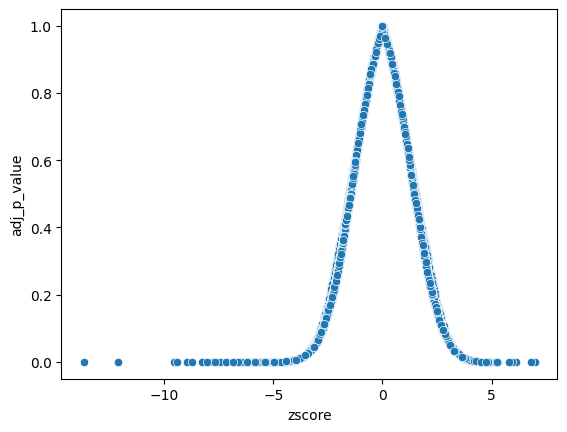

In [239]:
sns.scatterplot(data=perturbseq_results, x='zscore', y='adj_p_value');

In [182]:
df = all_results_df[all_results_df['contrast'] == 'Treg']
df.set_index('variable').loc['CTLA4']

baseMean       2840.803695
log_fc            1.807931
lfcSE             0.252782
stat              7.152129
p_value                0.0
adj_p_value            0.0
contrast              Treg
zscore            7.152129
Name: CTLA4, dtype: object

In [120]:
pseq_target = 'MTOR'
perturbseq_results = get_DE_results_long(adata_de, targets=[pseq_target], effect_estimates=['zscore'])
perturbseq_results.set_index('gene_name').groupby('culture_condition').significant.value_counts()

Series([], Name: count, dtype: int64)

In [88]:
perturbseq_results = get_DE_results_long(adata_de, targets=[pseq_target], effect_estimates=['zscore'])
perturbseq_results.set_index('gene_name').loc['FOXP3']

index   gene    zscore  adj_p_value  significant  \
gene_name                                                                       
FOXP3      ENSG00000049768_Stim8hr  FOXP3 -4.610460     0.022389         True   
FOXP3         ENSG00000049768_Rest  FOXP3 -3.431448     0.999792        False   

          culture_condition  target_contrast target_contrast_gene_name  
gene_name                                                               
FOXP3               Stim8hr  ENSG00000049768                     FOXP3  
FOXP3                  Rest  ENSG00000049768                     FOXP3

In [263]:
adata_de.var_names = adata_de.var['gene_name'].copy()
# Create a dictionary to store correlation results for all polarization conditions
all_correlation_results = {}

# Loop through all polarization conditions
for pol_condition in all_results['contrast'].unique():
    polarization_results = all_results[all_results['contrast'] == pol_condition].set_index('variable')
    polarization_results['zscore_polarization'] = polarization_results['log_fc'] / polarization_results['lfcSE']
    
    common_gs = np.intersect1d(polarization_results.index, adata_de.var['gene_name'])
    
    polarization_results = polarization_results.loc[common_gs].copy()
    pseq_results = pd.DataFrame(adata_de[:, common_gs].layers['zscore'], columns=common_gs, index=adata_de.obs_names)
    
    # Compute correlation coefficient and p-value for each row in pseq_results
    correlation_results = {}
    for idx in pseq_results.index:
        row_data = pseq_results.loc[idx]
        corr, p_value = stats.pearsonr(polarization_results['zscore_polarization'], row_data)
        correlation_results[idx] = {'correlation': corr, 'p_value': p_value, 'polarization': pol_condition}
    
    # Store results for this polarization condition
    all_correlation_results[pol_condition] = correlation_results

# Convert all results to a single DataFrame
correlation_dfs = []
for pol_condition, results in all_correlation_results.items():
    df = pd.DataFrame(results).T
    df.columns = ['correlation', 'p_value', 'polarization']
    correlation_dfs.append(df)

correlation_df = pd.concat(correlation_dfs)
correlation_df['target_gene_name'] = correlation_df.index.map(lambda x: adata_de.obs.loc[x, 'target_contrast_gene_name'])
correlation_df['condition'] = correlation_df.index.map(lambda x: adata_de.obs.loc[x, 'culture_condition'])

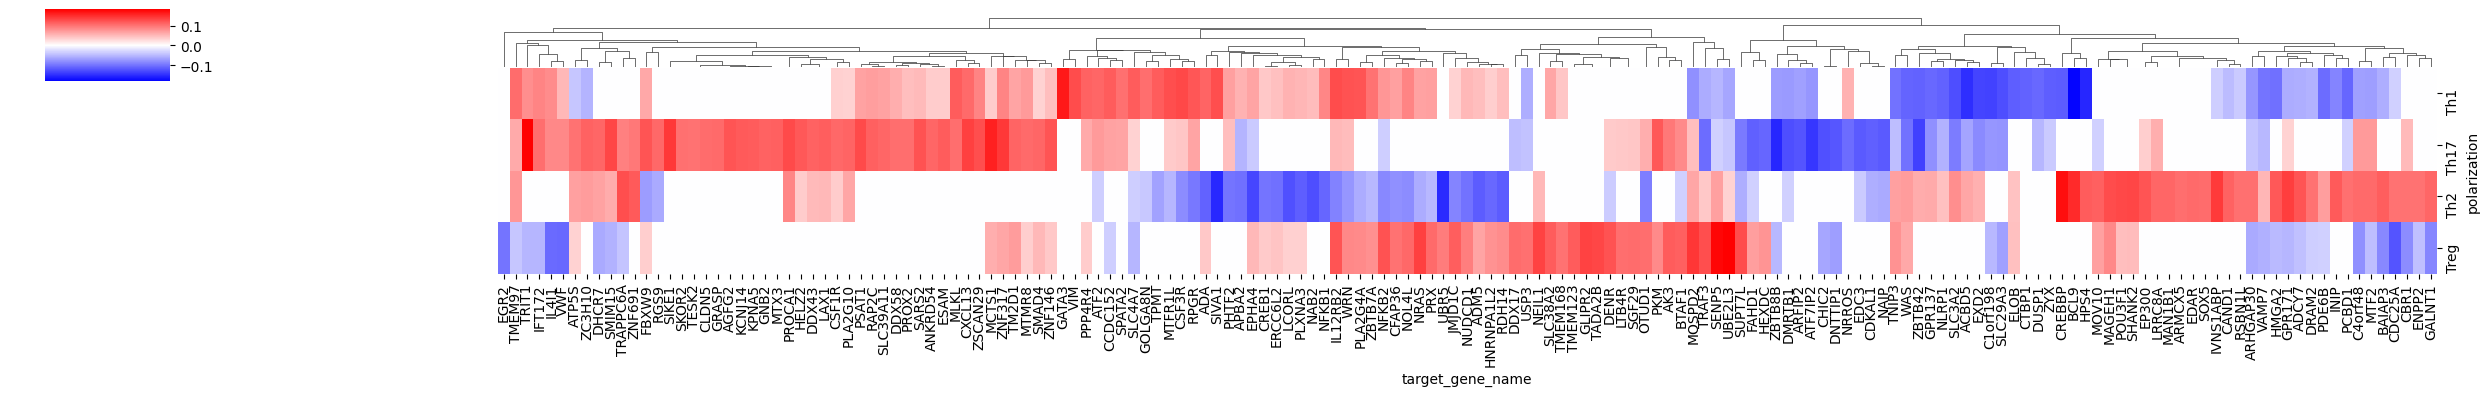

In [295]:
corr_wide = correlation_df.pivot_table(index=['target_gene_name', 'condition'], values='correlation', columns='polarization')
pval_wide = correlation_df.pivot_table(index=['target_gene_name', 'condition'], values='p_value', columns='polarization')
corr_wide[pval_wide >= 0.01] = 0
corr_wide = corr_wide.reset_index()
corr_wide = corr_wide[corr_wide['condition'] == 'Stim8hr'].drop('condition', axis=1).set_index('target_gene_name')

sns.clustermap(corr_wide[corr_wide.abs().max(1) > 0.1].astype(float).T, cmap='bwr', center=0, figsize=(25,4), xticklabels=True, row_cluster=False)

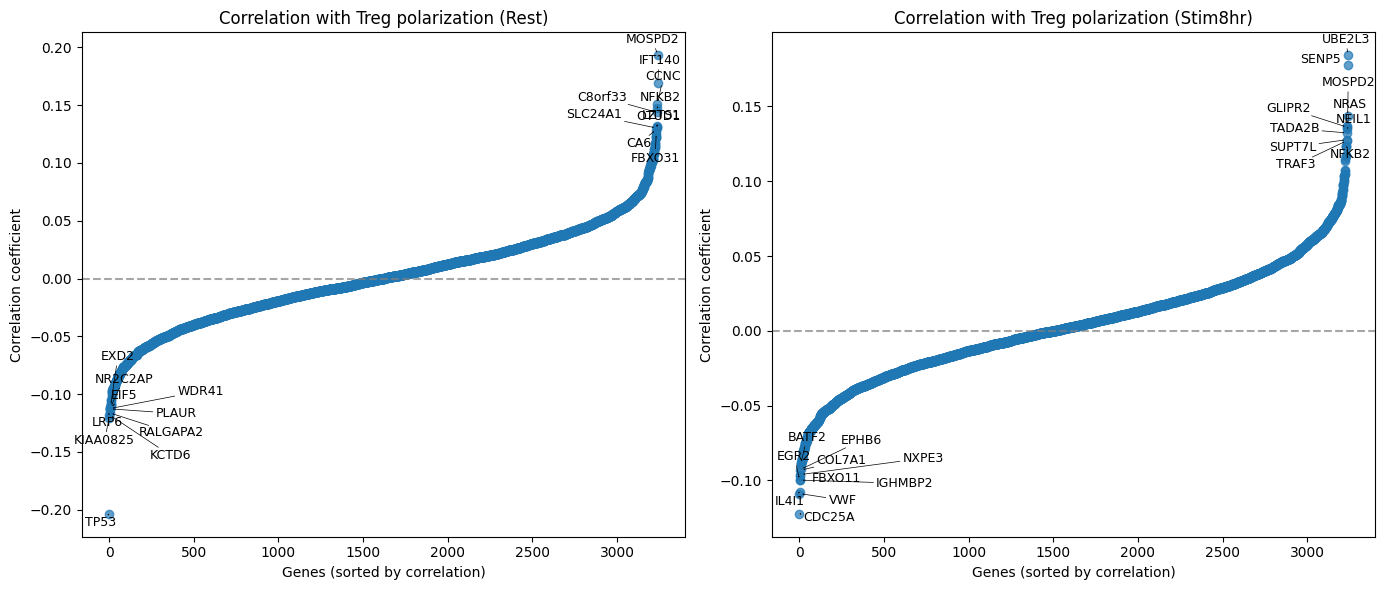

In [261]:
from adjustText import adjust_text
# Create a figure with 2 subplots (one for each condition)
ntop = 10
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
conditions = correlation_df['condition'].unique()

for i, condition in enumerate(conditions):
    # Filter data for this condition
    condition_df = correlation_df[correlation_df['condition'] == condition].copy()
    condition_df = condition_df.sort_values('correlation')
    
    # Create scatterplot
    axes[i].scatter(range(len(condition_df)), condition_df['correlation'], alpha=0.7)
    
    # Get top and bottom genes to annotate
    top_genes = condition_df.nlargest(ntop, 'correlation')
    bottom_genes = condition_df.nsmallest(ntop, 'correlation')
    genes_to_annotate = pd.concat([top_genes, bottom_genes])
    
    # Annotate points with adjustText to avoid overlaps
    texts = []
    for _, row in genes_to_annotate.iterrows():
        idx = condition_df.index.get_loc(row.name)
        text = axes[i].text(idx, row['correlation'], row['target_gene_name'], 
                          fontsize=9, ha='center', va='center')
        texts.append(text)
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5), ax=axes[i])
    
    # Add horizontal line at y=0
    axes[i].axhline(y=0, linestyle='--', color='gray', alpha=0.7)
    
    # Set title and labels
    axes[i].set_title(f'Correlation with {pol_condition} polarization ({condition})')
    axes[i].set_xlabel('Genes (sorted by correlation)')
    axes[i].set_ylabel('Correlation coefficient')

plt.tight_layout()